In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import glob
import json

from PIL import Image

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import transformers
import torch.nn as nn

from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.metrics import confusion_matrix as cm

import mlflow
import mlflow.pytorch

**Data Processing**

In [74]:
# Root directory of the project (NAS Server)
# ROOT_DIR = '\\\\nas.ads.mwn.de\\tume\\or1\\artificialintelligence_stud\\features_uncertainty\\'
# DATA_DIR = os.path.join(ROOT_DIR, "DATA")

In [3]:
# Root directory of the project (Goldie)
ROOT_DIR = '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification'
DATA_DIR = os.path.join(ROOT_DIR, "DATA")

In [76]:
# We are going to use all images from biopsy subfolders, for that we will create a list with all image filepaths
# img_dir = os.path.join(DATA_DIR, "og\\biopsy")
# sub_folders = os.listdir(img_dir)
# image_filepaths = []
# for i in range(len(sub_folders)):
    # path = os.path.join(img_dir, sub_folders[i])
    # os.chdir(path)
    # files = glob.glob(path + '/*.png')
    # image_filepaths.extend(files)

In [77]:
# Check pixel values in an image -> 4 values RGBA for each pixel
# img = PIL.Image.open('\\\\nas.ads.mwn.de\\tume\\or1\\artificialintelligence_stud\\features_uncertainty\\DATA\\og\\biopsy\\rEnch_Ench\\1.2.840.113654.2.70.1.1083274222498610994770793264856642342812066.png')
# pixels = list(img.getdata())

In [78]:
# def get_img_size(path):
#    width, height = Image.open(path).size
#    return width, height

In [79]:
# largest = max(image_filepaths, key=get_img_size)
# largest

In [80]:
# Create new folder in DATA_DIR for the resized images 
"""
os.makedirs(os.path.join(DATA_DIR, "og_resized"))
imgs_resized_path = os.path.join(DATA_DIR, "og_resized")
"""

'\nos.makedirs(os.path.join(DATA_DIR, "og_resized"))\nimgs_resized_path = os.path.join(DATA_DIR, "og_resized")\n'

In [81]:
# Each image has different size, we are going to resize and pad image to 224 x 224 and keeping its aspect ratio

"""
desired_size = 224

for image_fp in image_filepaths: 
    im = Image.open(image_fp)
    old_size = im.size
    ratio = float(desired_size)/max(old_size) # Resize input image so that its maximum size equals the desired_size
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size)
    new_im = Image.new("RGBA", (desired_size, desired_size)) # Create black square image of desired_size
    new_im.paste(im, ((desired_size-new_size[0])//2,(desired_size-new_size[1])//2)) # Paste the resized image on it to form new image ((0, 0, 0, 0) pixel values in the padding)

    # Save each new image in og_resized with same filename
    filename = os.path.basename(image_fp) 
    new_path = os.path.join(imgs_resized_path, filename)
    new_im.save(new_path, quality = 95, subsampling = 0) # Save image with a quality factor 95 (100 results in large files with hardly any gain in image quality)

"""

'\ndesired_size = 224\n\nfor image_fp in image_filepaths: \n    im = Image.open(image_fp)\n    old_size = im.size\n    ratio = float(desired_size)/max(old_size) # Resize input image so that its maximum size equals the desired_size\n    new_size = tuple([int(x*ratio) for x in old_size])\n    im = im.resize(new_size)\n    new_im = Image.new("RGBA", (desired_size, desired_size)) # Create black square image of desired_size\n    new_im.paste(im, ((desired_size-new_size[0])//2,(desired_size-new_size[1])//2)) # Paste the resized image on it to form new image ((0, 0, 0, 0) pixel values in the padding)\n\n    # Save each new image in og_resized with same filename\n    filename = os.path.basename(image_fp) \n    new_path = os.path.join(imgs_resized_path, filename)\n    new_im.save(new_path, quality = 95, subsampling = 0) # Save image with a quality factor 95 (100 results in large files with hardly any gain in image quality)\n\n'

In [4]:
# Create new list with resized images filepaths
img_resized_dir = os.path.join(DATA_DIR, "og_resized")
img_resized_filepaths = glob.glob(img_resized_dir + '/*.png')

In [5]:
# Convert img_resized_filepaths list to dataframe
img_resized_filepaths_df = pd.DataFrame(img_resized_filepaths, columns = ['img_resized_filepaths'])

In [6]:
# Extract filepath_basename of each img_resized_filepaths and add it as a new column of the dataframe
filepaths_basename = []
for i in img_resized_filepaths_df.index:
    basename = os.path.basename(img_resized_filepaths_df.iloc[i, 0])
    filepaths_basename.append(basename)
img_resized_filepaths_df['filepaths_basename'] = filepaths_basename

In [7]:
img_resized_filepaths_df

img_resized_filepaths  \
0    /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
1    /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
2    /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
3    /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
4    /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
..                                                 ...   
494  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
495  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
496  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
497  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   
498  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...   

                                    filepaths_basename  
0    1.2.840.113654.2.70.1.284813265891575331263680...  
1    1.2.840.113654.2.70.1.159433042852112525798270...  
2    1.2.840.113654.2.70.1.912301202778373590355213...  
3    1.2.840.113654.2.70.1.167398107750475245428254...  
4    1.2.840.113654.2.70.1.284811558923814412310213...  
..                                                 ...  
494  1.2.840.113654.2.70.1.323605098507849331478065...  
495  1.2.840.113654.2.70.1.322668982738026042461414...  
496  1.2.840.113654.2.70.1.176428586518545656810008...  
497  1.2.840.113654.2.70.1.337770670884851347415078...  
498  1.2.840.113654.2.70.1.264930964997237436283834...  

[499 rows x 2 columns]

In [8]:
# Read Labels.csv into a Dataframe
labels = pd.read_csv(os.path.join(DATA_DIR, 'Labels.csv'))
labels.head(6)

pseudo                                          file_name folder_name  \
0  QtK1z8SwbsU  1.2.840.113654.2.70.1.222667245592847789415273...  rEnch_Ench   
1  QtK1z8SwbsU  1.2.840.113654.2.70.1.323605098507849331478065...  rEnch_Ench   
2  hfUUPg12ZA8  1.2.840.113654.2.70.1.128478371465923432731011...  rEnch_Ench   
3  hfUUPg12ZA8  1.2.840.113654.2.70.1.298234710337899547712484...  rEnch_Ench   
4  rDHrRqnx_pE  1.2.840.113654.2.70.1.195063189938462051332980...  rEnch_Ench   
5  rDHrRqnx_pE  1.2.840.113654.2.70.1.298607946155006833422947...  rEnch_Ench   

       Entity  
0  Enchondrom  
1  Enchondrom  
2  Enchondrom  
3  Enchondrom  
4  Enchondrom  
5  Enchondrom

In [9]:
# Now we can merge img_resized_filepaths_df and labels since we have a common column that is filepaths_basename and file_name
imgsresized_labels_df = labels.merge(img_resized_filepaths_df, left_on = 'file_name', right_on = 'filepaths_basename', how = 'inner')
#imgsresized_labels_df.to_csv('\\\\nas.ads.mwn.de\\tume\\or1\\artificialintelligence_stud\\features_uncertainty\\DATA\\imgsresized_labels_df.csv', index = False)

# We can remove 'filepaths_basename' column since it is the same as 'file_name' column
imgsresized_labels_df = imgsresized_labels_df.drop(columns = ['filepaths_basename'])
imgsresized_labels_df

pseudo                                          file_name  \
0    QtK1z8SwbsU  1.2.840.113654.2.70.1.222667245592847789415273...   
1    QtK1z8SwbsU  1.2.840.113654.2.70.1.323605098507849331478065...   
2    hfUUPg12ZA8  1.2.840.113654.2.70.1.128478371465923432731011...   
3    hfUUPg12ZA8  1.2.840.113654.2.70.1.298234710337899547712484...   
4    rDHrRqnx_pE  1.2.840.113654.2.70.1.195063189938462051332980...   
..           ...                                                ...   
494  uCvLy0quuaY  1.2.840.113654.2.70.1.151649328324222336390927...   
495  UzK4MgsQSwY  1.2.840.113654.2.70.1.487709722852082300194970...   
496  UzK4MgsQSwY  1.2.840.113654.2.70.1.118383545388163821719409...   
497  l9fyEv34SO4  1.2.840.113654.2.70.1.863067033470691809291566...   
498  l9fyEv34SO4  1.2.840.113654.2.70.1.316693444220788600261363...   

    folder_name      Entity                              img_resized_filepaths  
0    rEnch_Ench  Enchondrom  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
1    rEnch_Ench  Enchondrom  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
2    rEnch_Ench  Enchondrom  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
3    rEnch_Ench  Enchondrom  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
4    rEnch_Ench  Enchondrom  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
..          ...         ...                                                ...  
494   rEnch_ACT         ACT  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
495   rEnch_ACT         ACT  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
496   rEnch_ACT         ACT  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
497   rEnch_ACT         ACT  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  
498   rEnch_ACT         ACT  /home/inesdv/Documents/Uncertainty-in-Bone-Tum...  

[499 rows x 5 columns]

In [10]:
# Create a list of dictionaries of each row in the data frame
imgsresized_labels = imgsresized_labels_df.to_dict('records')
imgsresized_labels

[{'pseudo': 'QtK1z8SwbsU',
  'file_name': '1.2.840.113654.2.70.1.2226672455928477894152730490424962775352247.png',
  'folder_name': 'rEnch_Ench',
  'Entity': 'Enchondrom',
  'img_resized_filepaths': '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/DATA/og_resized/1.2.840.113654.2.70.1.2226672455928477894152730490424962775352247.png'},
 {'pseudo': 'QtK1z8SwbsU',
  'file_name': '1.2.840.113654.2.70.1.323605098507849331478065383107989555732249.png',
  'folder_name': 'rEnch_Ench',
  'Entity': 'Enchondrom',
  'img_resized_filepaths': '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/DATA/og_resized/1.2.840.113654.2.70.1.323605098507849331478065383107989555732249.png'},
 {'pseudo': 'hfUUPg12ZA8',
  'file_name': '1.2.840.113654.2.70.1.12847837146592343273101157550551902968[1]924.png',
  'folder_name': 'rEnch_Ench',
  'Entity': 'Enchondrom',
  'img_resized_filepaths': '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/DATA/og_resized/1.2.840.113654.

pseudo: kImVhcgRwug
file_name: 1.2.840.113654.2.70.1.97987411907853309877271696297096466499.png
folder_name: rACT_ACT
Entity: ACT
(224, 224)


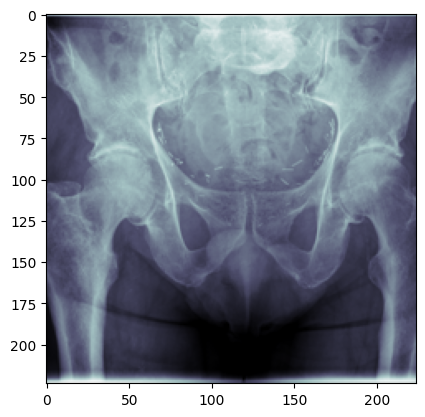

In [11]:
# Print example
example = imgsresized_labels[414]
list_of_values = []
for values in example.items():
    list_of_values.append(values)

for i in range(0, len(list_of_values)):
    if i < 4:
        print(f'{list_of_values[i][0]}: {list_of_values[i][1]}')
    else:
        im = Image.open(list_of_values[i][1])
        pixels = list(im.getdata())
        # print(f'Pixel values: {pixels}')
        print(im.size)
        plt.imshow(im)
        plt.show()

In [12]:
# Find in imgsresized_labels_df if there images from the same patient by checking duplicated in 'pseudo' column
repeated_patients = imgsresized_labels_df.pivot_table(index = ['pseudo'], aggfunc = 'size')
repeated_patients

pseudo
-aA6CcrSgJs    2
-bEIOqdEsG0    1
-hJiXlv7wLw    1
-wkZGUF-ejA    1
-zBCn5p1MvE    2
              ..
zYr9Ex3aBUQ    1
zgpFGxx-9sM    2
zmpu3iVOtKo    2
zyFoiW5njK8    2
zzLdaAPD8Jo    3
Length: 247, dtype: int64

In [13]:
# We can see better that one patient can have multiple images
group_by = imgsresized_labels_df.groupby(['pseudo', 'file_name', 'img_resized_filepaths'])
group_by.first()

folder_name  \
pseudo      file_name                                          img_resized_filepaths                                            
-aA6CcrSgJs 1.2.840.113654.2.70.1.2379782271622470593740757... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
            1.2.840.113654.2.70.1.2941550867553239835355142... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
-bEIOqdEsG0 1.2.840.113654.2.70.1.2695797822393150275640739... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...   rACT_Ench   
-hJiXlv7wLw 1.2.840.113654.2.70.1.1823813998056666951056323... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
-wkZGUF-ejA 1.2.840.113654.2.70.1.2966475133826910769293618... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
...                                                                                                                       ...   
zyFoiW5njK8 1.2.840.113654.2.70.1.1594330428521125257982705... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
            1.2.840.113654.2.70.1.2208385848700357317514058... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
zzLdaAPD8Jo 1.2.840.113654.2.70.1.1727269616141967319696327... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
            1.2.840.113654.2.70.1.7061920560181354916352747... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   
            1.2.840.113654.2.70.1.8249490485667631439342189... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  rEnch_Ench   

                                                                                                                       Entity  
pseudo      file_name                                          img_resized_filepaths                                           
-aA6CcrSgJs 1.2.840.113654.2.70.1.2379782271622470593740757... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
            1.2.840.113654.2.70.1.2941550867553239835355142... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
-bEIOqdEsG0 1.2.840.113654.2.70.1.2695797822393150275640739... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
-hJiXlv7wLw 1.2.840.113654.2.70.1.1823813998056666951056323... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
-wkZGUF-ejA 1.2.840.113654.2.70.1.2966475133826910769293618... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
...                                                                                                                       ...  
zyFoiW5njK8 1.2.840.113654.2.70.1.1594330428521125257982705... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
            1.2.840.113654.2.70.1.2208385848700357317514058... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
zzLdaAPD8Jo 1.2.840.113654.2.70.1.1727269616141967319696327... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
            1.2.840.113654.2.70.1.7061920560181354916352747... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  
            1.2.840.113654.2.70.1.8249490485667631439342189... /home/inesdv/Documents/Uncertainty-in-Bone-Tumo...  Enchondrom  

[499 rows x 2 columns]

In [14]:
# Count how many Enchondroma and ACT cases we have
count_entities = imgsresized_labels_df.pivot_table(columns = ['Entity'], aggfunc = 'size')
count_entities

Entity
ACT            85
Enchondrom    414
dtype: int64

In [15]:
# Perform train and test split taking into account images from the same patient
groups = imgsresized_labels_df['pseudo']
group_shuffle_split = GroupShuffleSplit(n_splits = 1, test_size = 0.10, random_state = 42) # Test set ratio is 10
#group_shuffle_split = GroupShuffleSplit(n_splits = 1, test_size = 0.20, random_state = 42) # Test set ratio is 10
train_indices, test_indices = next(group_shuffle_split.split(imgsresized_labels_df, groups = groups))

initial_train = imgsresized_labels_df.iloc[train_indices]
test_set = imgsresized_labels_df.iloc[test_indices]

In [16]:
print("Training data size:", len(initial_train))
print("Test data size:", len(test_set))

Training data size: 453
Test data size: 46


In [17]:
directory = DATA_DIR
directory

'/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/DATA'

Test Set Entity Counts: Entity
Enchondrom    37
ACT            9
Name: count, dtype: int64


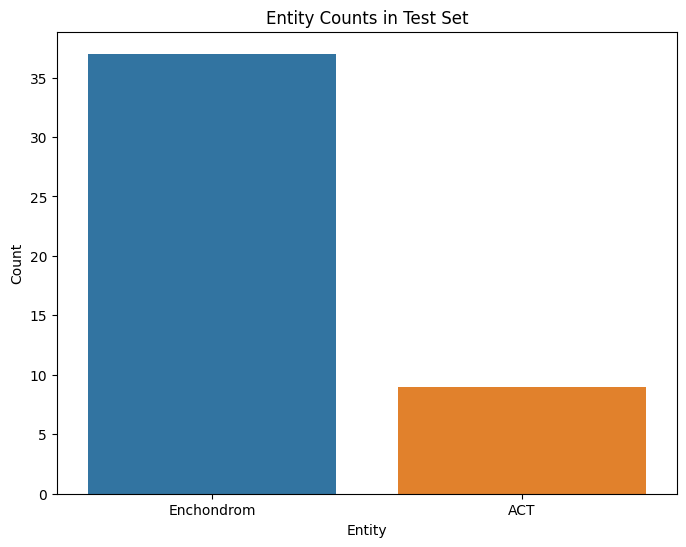

In [18]:
entity_counts_test = test_set['Entity'].value_counts()
print("Test Set Entity Counts:", entity_counts_test)

ench_test_count = entity_counts_test.loc['Enchondrom']
act_test_count = entity_counts_test.loc['ACT']
plt.figure(figsize=(8, 6))
sns.barplot(x=['Enchondrom', 'ACT'], y=[ench_test_count, act_test_count])
plt.title("Entity Counts in Test Set")
plt.xlabel("Entity")
plt.ylabel("Count")
plt.show()

# Save test set data frame as .csv files in our DATA Directory
test_set_filename = f"test_set.csv"
test_filepath = directory + '/' + test_set_filename
test_set.to_csv(test_filepath, index=False)

In [20]:
# Perform train and validation split taking into account images from the same patient
groups = initial_train['pseudo']
#group_shuffle_split = GroupShuffleSplit(n_splits = 1, test_size = 0.10, random_state = 42) # Validation set ratio is 10
group_shuffle_split = GroupShuffleSplit(n_splits = 1, test_size = 0.20, random_state = 42) # Validation set ratio is 20
train_indices, val_indices = next(group_shuffle_split.split(initial_train, groups = groups))

train_set = initial_train.iloc[train_indices]
val_set = initial_train.iloc[val_indices]

In [21]:
print("Training data size:", len(train_set))
print("Validation data size:", len(val_set))

Training data size: 352
Validation data size: 101


In [22]:
entity_counts_train = train_set['Entity'].value_counts()
print("Train Set Entity Counts:", entity_counts_train)

Train Set Entity Counts: Entity
Enchondrom    295
ACT            57
Name: count, dtype: int64


In [23]:
entity_counts_val = val_set['Entity'].value_counts()
print("Val Set Entity Counts:", entity_counts_val)

Val Set Entity Counts: Entity
Enchondrom    82
ACT           19
Name: count, dtype: int64


In [24]:
# Save train set and validation set for each fold data frames as .csv files in our DATA Directory
train_set_filename = f"train.csv"
train_filepath = directory + '/' + train_set_filename
train_set.to_csv(train_filepath, index=False)

val_set_filename = f"val.csv"
val_filepath = directory + '/' + val_set_filename
val_set.to_csv(val_filepath, index=False)

In [25]:
# Create Custom Dataset which returns a dictionary with 'pixel_values' and 'labels'
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Load the image using the file_path
        image = Image.open(row['img_resized_filepaths']).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        
        entity = row['Entity']

        if entity == 'ACT':
            label = 0
        else:
            label = 1 #Enchondrom will be label 1

        # Return a tuple
        return {'pixel_values': image, 'labels': label}

In [26]:
# Define data augmentation transforms (only for training set)
train_transforms = transforms.Compose([
    #transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.2),
    #transforms.RandomVerticalFlip(p=0.2),
    #transforms.ColorJitter(brightness = 0.01),
    #transforms.GaussianBlur(kernel_size=(3, 9), sigma=(0.1, 4)),
    #transforms.RandomAdjustSharpness(sharpness_factor = 2),
    #transforms.RandomAffine(degrees=0, shear=15),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [27]:
# Define Transforms
transform = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [28]:
train_dataset_no_augmentation = CustomDataset(train_set, transform = transform)

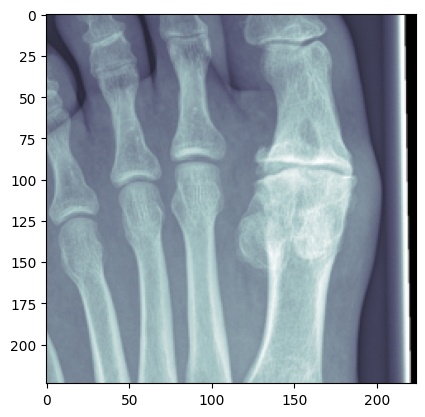

In [29]:
train_image_example_no_aug = train_dataset_no_augmentation[2]['pixel_values']
numpy_image = train_image_example_no_aug.cpu().numpy()
numpy_image = numpy_image.transpose(1, 2, 0)
numpy_image = numpy_image.clip(0, 1)
plt.imshow(numpy_image)

In [30]:
# Create Custom Datasets
train_dataset_augmentation = CustomDataset(train_set, transform = train_transforms)
#train_dataset = CustomDataset(train_set, transform = transform)
val_dataset = CustomDataset(val_set, transform = transform)
test_dataset = CustomDataset(test_set, transform = transform)

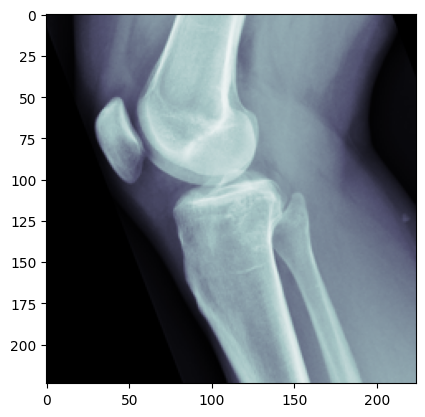

In [31]:
train_image_example = train_dataset_augmentation[4]['pixel_values']
numpy_image = train_image_example.cpu().numpy()
numpy_image = numpy_image.transpose(1, 2, 0)
numpy_image = numpy_image.clip(0, 1)
plt.imshow(numpy_image)

In [32]:
train_image_example

tensor([[[0.0471, 0.0471, 0.0431,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0431, 0.0431,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.5647, 0.5608],
         [0.0000, 0.0000, 0.0000,  ..., 0.5647, 0.5608, 0.5647],
         [0.0000, 0.0000, 0.0000,  ..., 0.5686, 0.5647, 0.5686]],

        [[0.0471, 0.0471, 0.0431,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0431, 0.0431,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0471, 0.0471,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.6471, 0.6588, 0.6549],
         [0.0000, 0.0000, 0.0000,  ..., 0.6588, 0.6549, 0.6588],
         [0.0000, 0.0000, 0.0000,  ..., 0.6627, 0.6588, 0.6627]],

        [[0.0667, 0.0627, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
         [0.0667, 0.0627, 0.0588,  ..., 0.0000, 0.0000, 0.0000],
         [0.0627, 0.0627, 0.0627,  ..., 0.0000, 0.0000, 0.

In [33]:
# Function to return stacked pixel_values and tensor labels
def features_and_labels(dataset):
    features = []
    labels = []
    for data in dataset:
        pixel_values = data['pixel_values']
        label = data['labels']
        features.append(pixel_values)
        labels.append(label)

    return torch.stack(features), torch.tensor(labels)

In [34]:
# Get features and labels from datasets
# train_features, train_labels = features_and_labels(train_dataset)
train_features, train_labels = features_and_labels(train_dataset_augmentation)
val_features, val_labels = features_and_labels(val_dataset)
test_features, test_labels = features_and_labels(test_dataset)

In [35]:
# Create custom datasets
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_features, val_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

In [36]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False)

**Model Development**

Base Model - 'google/vit-base-patch16-224-in21k' 85M parameters

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
# Define the model

from transformers import ViTForImageClassification, ViTFeatureExtractor

# Loading ViT Feature Extractor from the pre-trained model to apply the correct transformations 

model_name = 'google/vit-base-patch16-224-in21k'
# model_name = 'google/vit-base-patch32-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

labels = np.unique(imgsresized_labels_df['Entity'])

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(device)

"""
model = ViTModel.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(device)
"""

model.classifier = torch.nn.Linear(model.config.hidden_size, len(labels)).to(device)

/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model.vit.encoder

ViTEncoder(
  (layer): ModuleList(
    (0-11): 12 x ViTLayer(
      (attention): ViTAttention(
        (attention): ViTSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (output): ViTSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (intermediate): ViTIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): ViTOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (layernorm

In [40]:
total_params = sum(p.numel() for p in model.parameters())
print(f"google/vit-base-patch16-224-in21k number of parameters: {total_params}")
#print(f"google/vit-base-patch32-224-in21k number of parameters: {total_params}")

google/vit-base-patch16-224-in21k number of parameters: 85800194


In [41]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [42]:
# Set the number of layers to freeze
n = 12  # Change this to the number of layers you want to freeze

# Freeze the first n layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the later layers that you want to fine-tune
for param in model.vit.encoder.layer[n:].parameters():
    param.requires_grad = True

# Optionally, you can also specify which layers to unfreeze by name
# For example, to unfreeze layers with names starting with "classifier":
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

# Check which layers are frozen and which are not
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Grad: {param.requires_grad}")


Layer: vit.embeddings.cls_token, Requires Grad: False
Layer: vit.embeddings.position_embeddings, Requires Grad: False
Layer: vit.embeddings.patch_embeddings.projection.weight, Requires Grad: False
Layer: vit.embeddings.patch_embeddings.projection.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.query.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.query.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.key.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.key.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.value.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.value.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.output.dense.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.output.dense.bias, Requires Grad: False
Layer: vit.encoder.layer.0.intermediate.dense.weight, Requires Grad: False
Layer: vit.en

In [120]:
"""
dropout_rate = 0.1  

# Add dropout layers to the model
model.vit.embeddings.patch_embeddings = nn.Sequential(
    nn.Dropout(dropout_rate),  # Add dropout layer before patch embeddings
    model.vit.embeddings.patch_embeddings
)
"""

'\ndropout_rate = 0.1  \n\n# Add dropout layers to the model\nmodel.vit.embeddings.patch_embeddings = nn.Sequential(\n    nn.Dropout(dropout_rate),  # Add dropout layer before patch embeddings\n    model.vit.embeddings.patch_embeddings\n)\n'

Tiny Model - 'facebook/deit-tiny-patch16-224' 5M parameters

In [121]:
# Define the model

from transformers import ViTForImageClassification, ViTFeatureExtractor

# Loading ViT Feature Extractor from the pre-trained model to apply the correct transformations 

model_name = 'facebook/deit-tiny-patch16-224'

labels = np.unique(imgsresized_labels_df['Entity'])
"""
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(device)
"""

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels), ignore_mismatched_sizes=True
).to(device)

model.classifier = torch.nn.Linear(model.config.hidden_size, len(labels)).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1

In [123]:
# Set the number of layers to freeze
n = 12  # Change this to the number of layers you want to freeze

# Freeze the first n layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the later layers that you want to fine-tune
for param in model.vit.encoder.layer[n:].parameters():
    param.requires_grad = True

# Optionally, you can also specify which layers to unfreeze by name
# For example, to unfreeze layers with names starting with "classifier":
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

# Check which layers are frozen and which are not
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Grad: {param.requires_grad}")

Layer: vit.embeddings.cls_token, Requires Grad: False
Layer: vit.embeddings.position_embeddings, Requires Grad: False
Layer: vit.embeddings.patch_embeddings.projection.weight, Requires Grad: False
Layer: vit.embeddings.patch_embeddings.projection.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.query.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.query.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.key.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.key.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.value.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.attention.value.bias, Requires Grad: False
Layer: vit.encoder.layer.0.attention.output.dense.weight, Requires Grad: False
Layer: vit.encoder.layer.0.attention.output.dense.bias, Requires Grad: False
Layer: vit.encoder.layer.0.intermediate.dense.weight, Requires Grad: False
Layer: vit.en

In [124]:
"""
class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets):
    
        # Apply weights to the loss if provided
        if self.weight is not None:
            # Compute the weighted cross-entropy loss
            loss = torch.nn.functional.cross_entropy(inputs, targets, weight=self.weight)
        else:
            # If no weights are provided, compute regular cross-entropy loss
            loss = torch.nn.functional.cross_entropy(inputs, targets)
        
        return loss

"""


'\nclass WeightedCrossEntropyLoss(torch.nn.Module):\n    def __init__(self, weight=None):\n        super(WeightedCrossEntropyLoss, self).__init__()\n        self.weight = weight\n\n    def forward(self, inputs, targets):\n    \n        # Apply weights to the loss if provided\n        if self.weight is not None:\n            # Compute the weighted cross-entropy loss\n            loss = torch.nn.functional.cross_entropy(inputs, targets, weight=self.weight)\n        else:\n            # If no weights are provided, compute regular cross-entropy loss\n            loss = torch.nn.functional.cross_entropy(inputs, targets)\n        \n        return loss\n\n'

In [125]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        #ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        ce_loss = F.cross_entropy(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        return focal_loss

        #if self.reduction == 'mean':
            #return focal_loss.mean()
        #elif self.reduction == 'sum':
            #return focal_loss.sum()
        #else:


In [37]:
# Create the loss function with weights (you can set the weights accordingly)
# As our negative class (ACT) has only 17% of all samples (85/499) we set a higher weight for the negative class
# We can assign a weight to each class that it is inversely proportional to its frequency (in the training set?). 
# For ACT we assign a weight of (328 training samples / 43 ACT samples = 7,63) and for Ench (328 training samples / 284 Ench samples = 1,15)
# For ACT we assign a weight of (499 samples / (2 num_classes *85 ACT samples = 2,94) and for Ench (499 samples / (2 num_classes *414 Ench samples = 0.61)
weights = torch.Tensor([2.94, 0.61]).to(device)

In [38]:
# Define Loss Function and Optimizer
# criterion = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss(weight = weights)
#criterion = FocalLoss(gamma = 2)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

In [128]:
"""
# Define Early Stopping Criteria
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

"""

'\n# Define Early Stopping Criteria\nclass EarlyStopping:\n    def __init__(self, patience=5, delta=0):\n        self.patience = patience\n        self.delta = delta\n        self.counter = 0\n        self.best_score = None\n        self.early_stop = False\n\n    def __call__(self, val_loss):\n        if self.best_score is None:\n            self.best_score = val_loss\n        elif val_loss > self.best_score + self.delta:\n            self.counter += 1\n            if self.counter >= self.patience:\n                self.early_stop = True\n        else:\n            self.best_score = val_loss\n            self.counter = 0\n\n'

In [129]:
"""
# Initialize Early Stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)
"""

'\n# Initialize Early Stopping\nearly_stopping = EarlyStopping(patience=10, delta=0.001)\n'

**Model Training and Validation**

Epoch [1/100], Training Loss: 0.7341, Training Accuracy: 0.5739
Epoch [1/100], Validation Loss: 0.7378, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4528, Sensitivity: 0.6951, Specificity: 0.2105
F1-Score: 0.7403


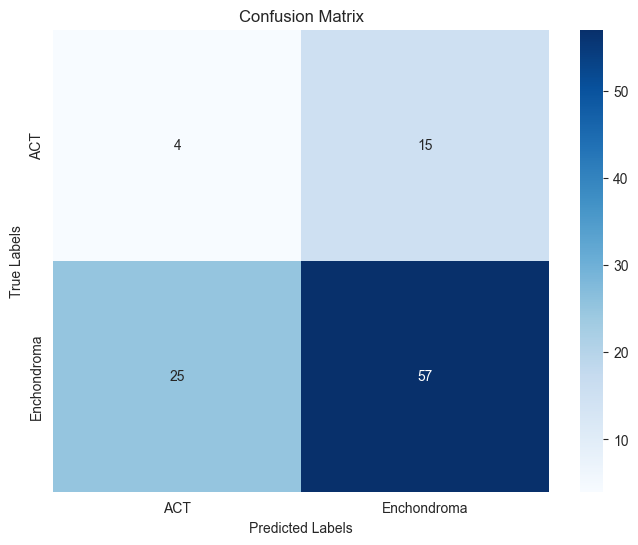

Epoch [2/100], Training Loss: 0.7367, Training Accuracy: 0.5739
Epoch [2/100], Validation Loss: 0.7279, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4528, Sensitivity: 0.6951, Specificity: 0.2105
F1-Score: 0.7403


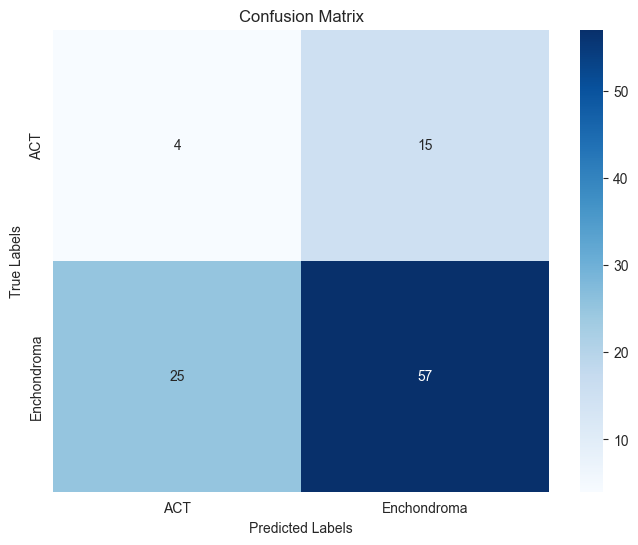

Epoch [3/100], Training Loss: 0.7505, Training Accuracy: 0.5739
Epoch [3/100], Validation Loss: 0.7359, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4528, Sensitivity: 0.6951, Specificity: 0.2105
F1-Score: 0.7403


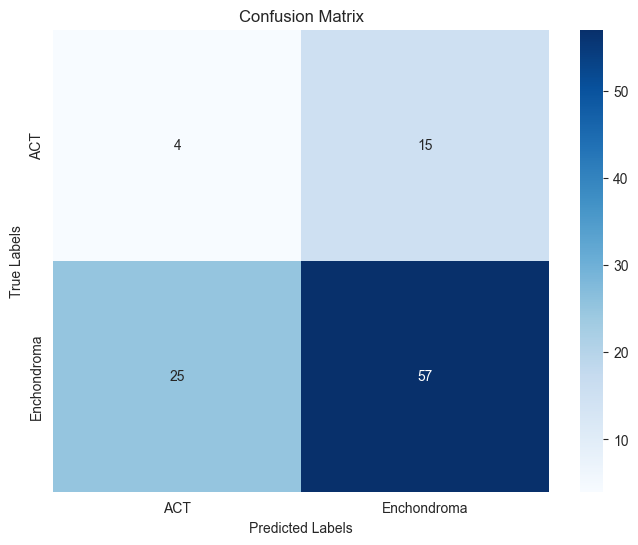

Epoch [4/100], Training Loss: 0.7450, Training Accuracy: 0.5767
Epoch [4/100], Validation Loss: 0.7355, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


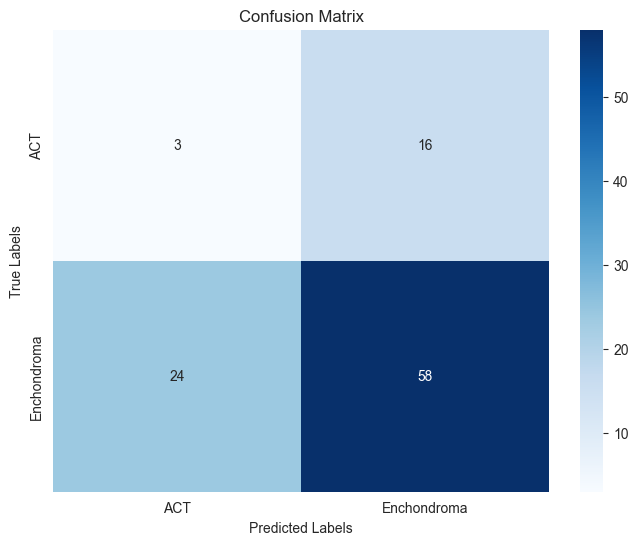

Epoch [5/100], Training Loss: 0.7361, Training Accuracy: 0.5739
Epoch [5/100], Validation Loss: 0.7307, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


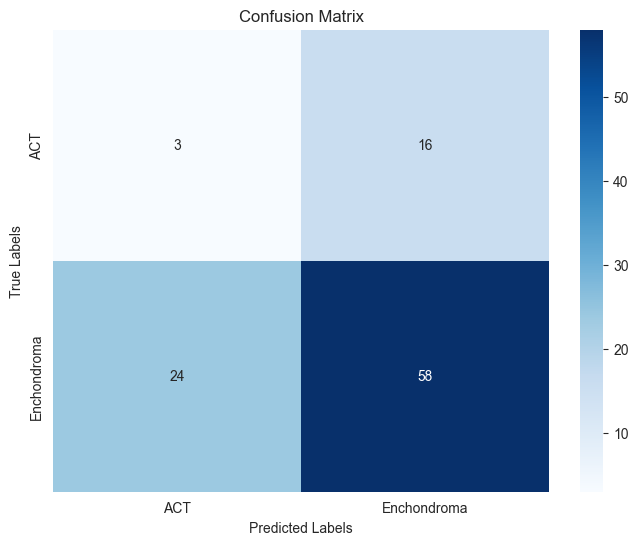

Epoch [6/100], Training Loss: 0.7292, Training Accuracy: 0.5767
Epoch [6/100], Validation Loss: 0.7332, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


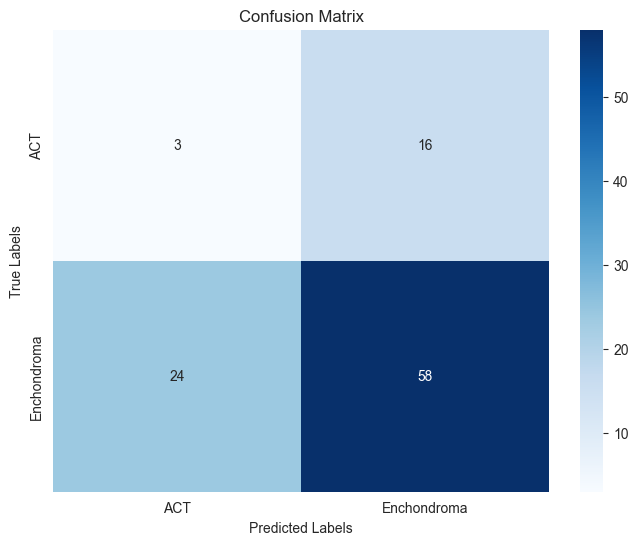

Epoch [7/100], Training Loss: 0.7433, Training Accuracy: 0.5767
Epoch [7/100], Validation Loss: 0.7438, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


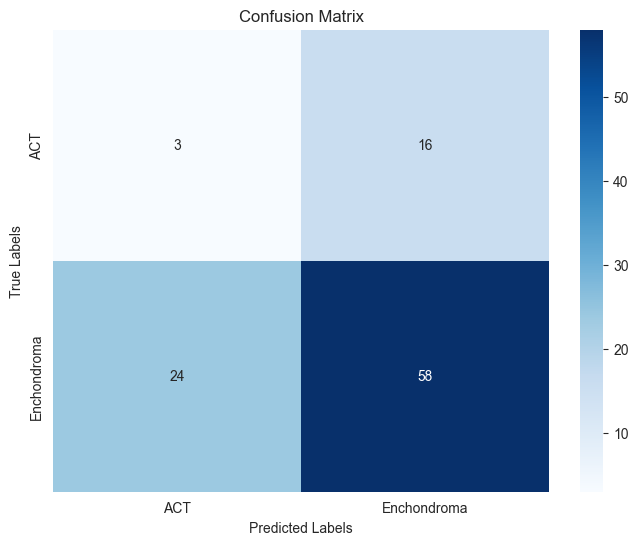

Epoch [8/100], Training Loss: 0.7344, Training Accuracy: 0.5767
Epoch [8/100], Validation Loss: 0.7442, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


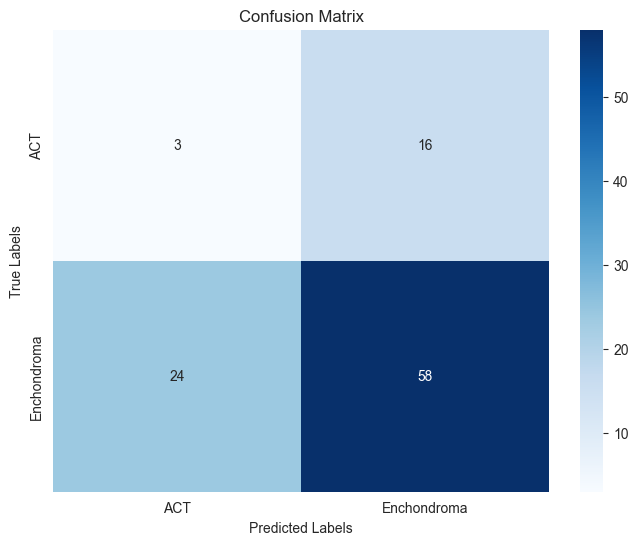

Epoch [9/100], Training Loss: 0.7480, Training Accuracy: 0.5795
Epoch [9/100], Validation Loss: 0.7538, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


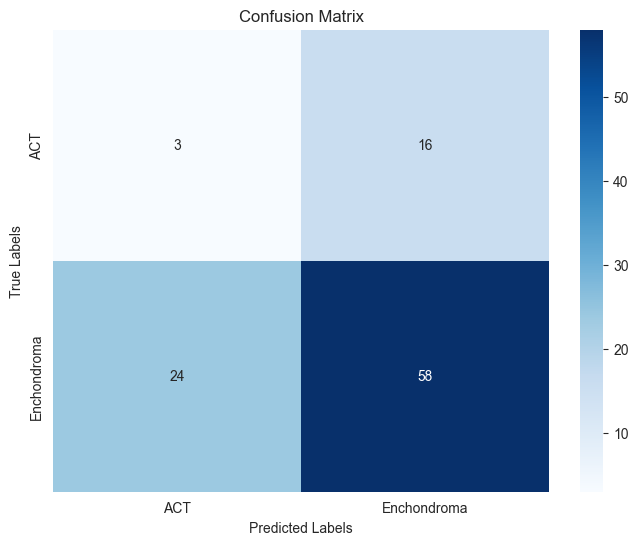

Epoch [10/100], Training Loss: 0.7365, Training Accuracy: 0.5795
Epoch [10/100], Validation Loss: 0.7355, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


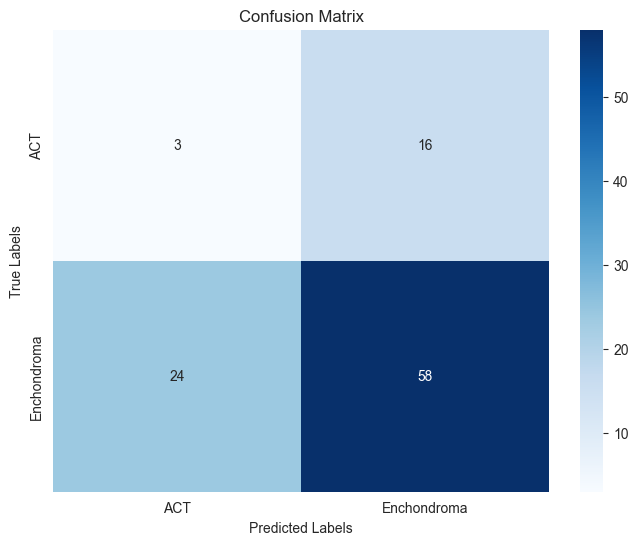

Epoch [11/100], Training Loss: 0.7359, Training Accuracy: 0.5795
Epoch [11/100], Validation Loss: 0.7288, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


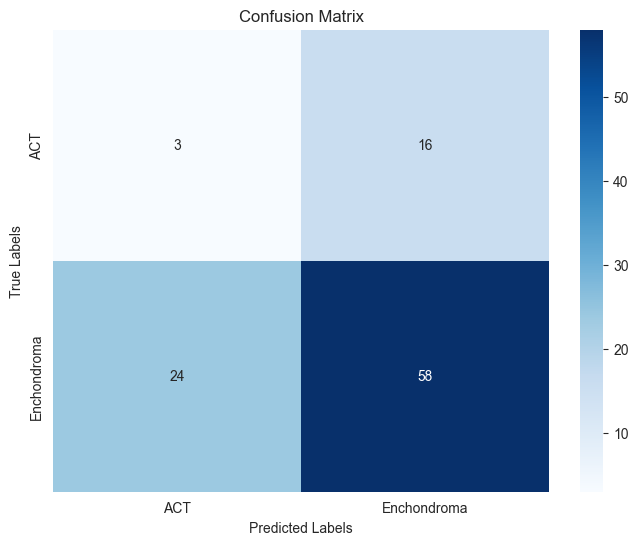

Epoch [12/100], Training Loss: 0.7371, Training Accuracy: 0.5795
Epoch [12/100], Validation Loss: 0.7463, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


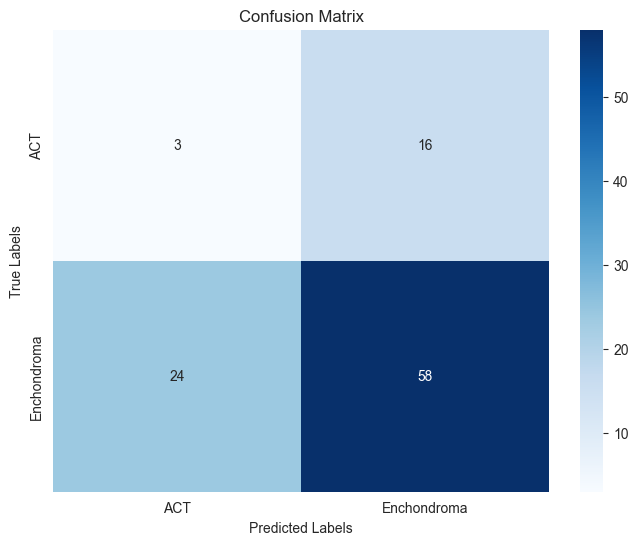

Epoch [13/100], Training Loss: 0.7367, Training Accuracy: 0.5795
Epoch [13/100], Validation Loss: 0.7384, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


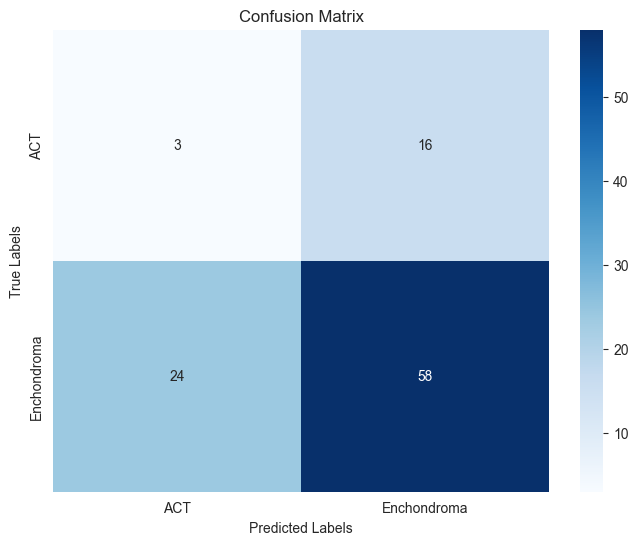

Epoch [14/100], Training Loss: 0.7306, Training Accuracy: 0.5795
Epoch [14/100], Validation Loss: 0.7367, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


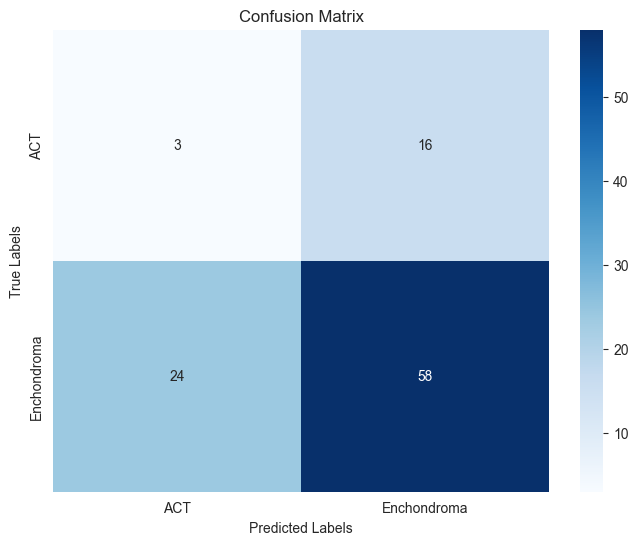

Epoch [15/100], Training Loss: 0.7321, Training Accuracy: 0.5795
Epoch [15/100], Validation Loss: 0.7294, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


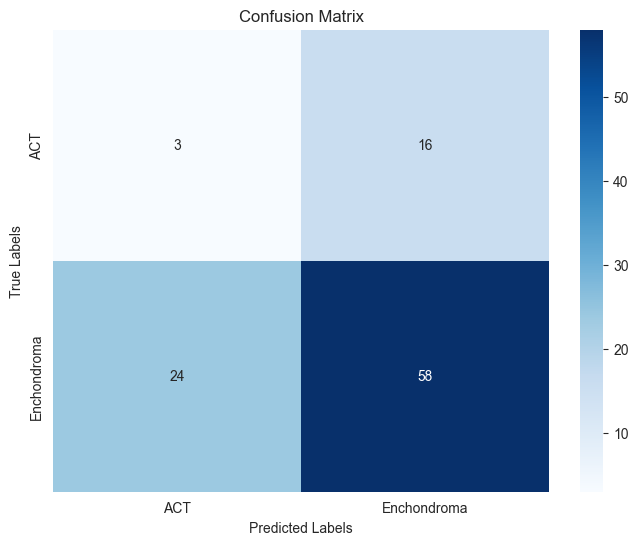

Epoch [16/100], Training Loss: 0.7315, Training Accuracy: 0.5795
Epoch [16/100], Validation Loss: 0.7480, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


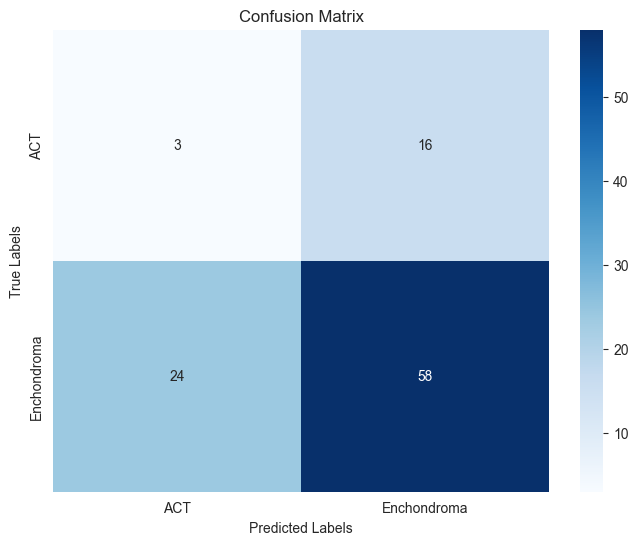

Epoch [17/100], Training Loss: 0.7246, Training Accuracy: 0.5795
Epoch [17/100], Validation Loss: 0.7488, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


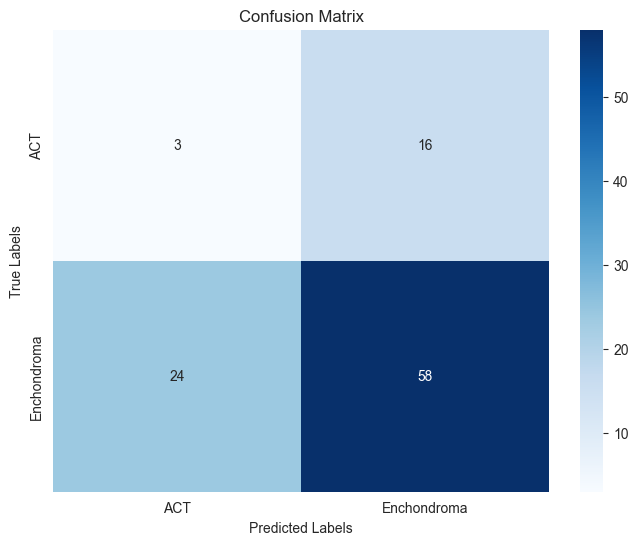

Epoch [18/100], Training Loss: 0.7308, Training Accuracy: 0.5795
Epoch [18/100], Validation Loss: 0.7502, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


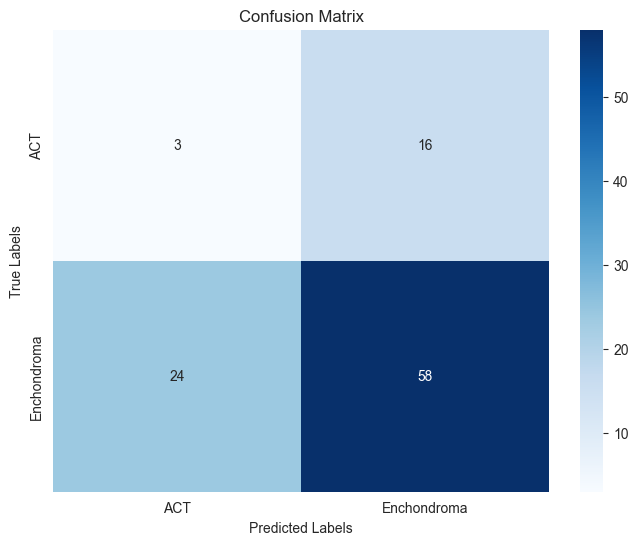

Epoch [19/100], Training Loss: 0.7390, Training Accuracy: 0.5795
Epoch [19/100], Validation Loss: 0.7270, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


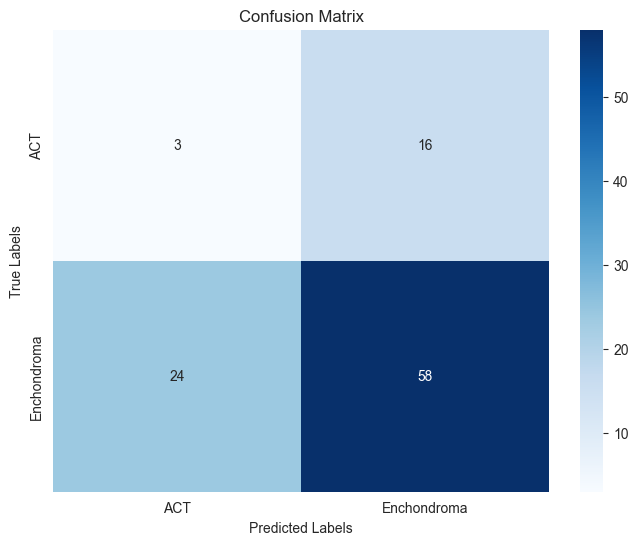

Epoch [20/100], Training Loss: 0.7432, Training Accuracy: 0.5795
Epoch [20/100], Validation Loss: 0.7470, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


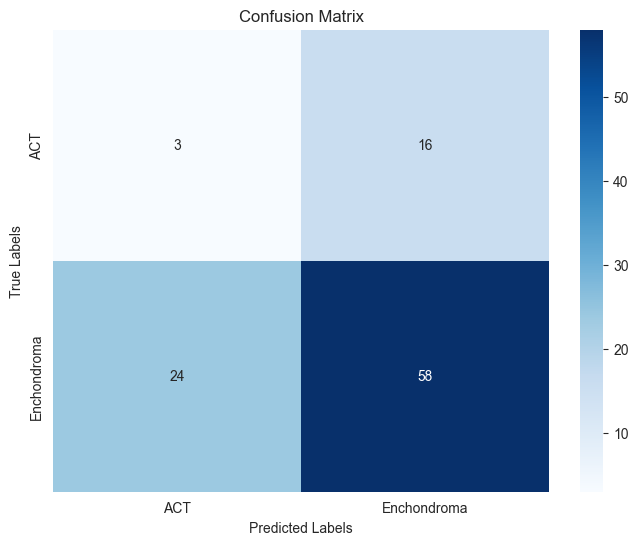

Epoch [21/100], Training Loss: 0.7292, Training Accuracy: 0.5795
Epoch [21/100], Validation Loss: 0.7345, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


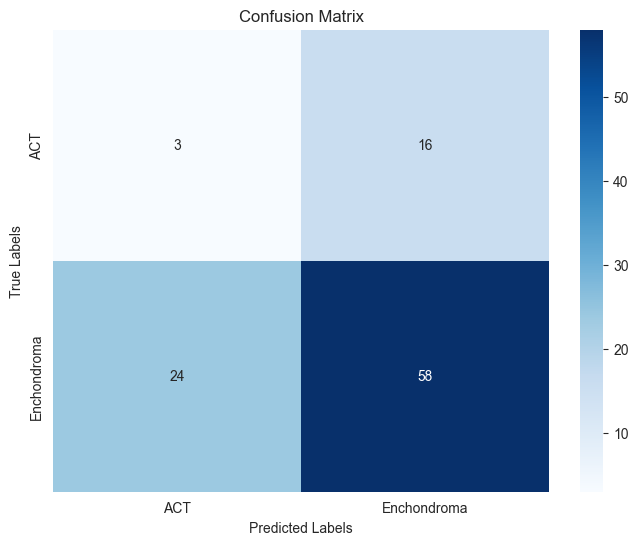

Epoch [22/100], Training Loss: 0.7287, Training Accuracy: 0.5795
Epoch [22/100], Validation Loss: 0.7537, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


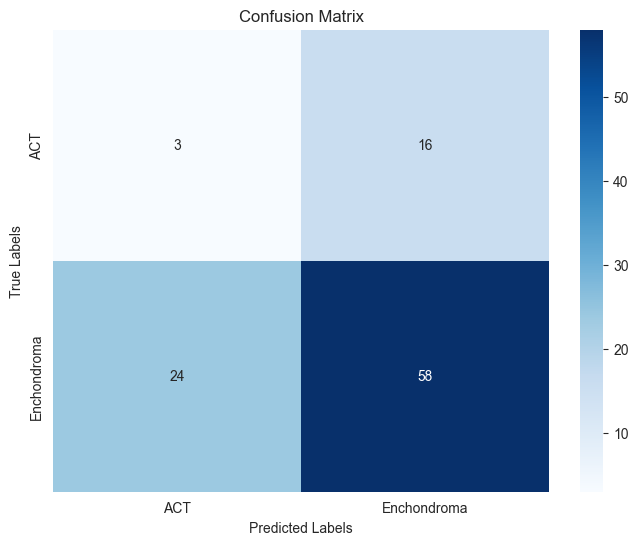

Epoch [23/100], Training Loss: 0.7365, Training Accuracy: 0.5795
Epoch [23/100], Validation Loss: 0.7684, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


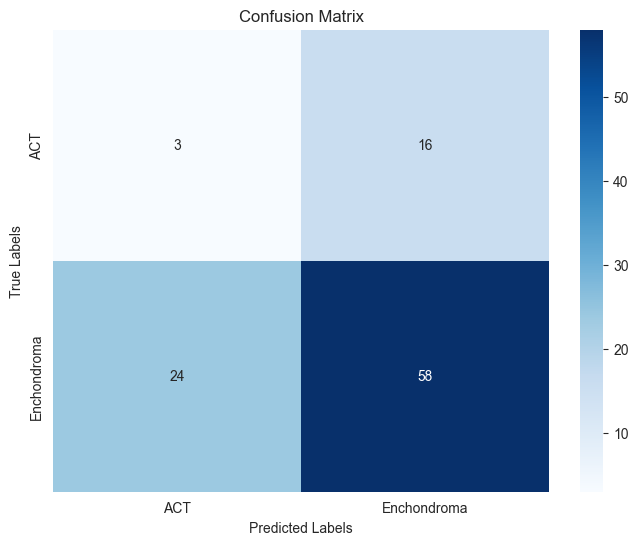

Epoch [24/100], Training Loss: 0.7381, Training Accuracy: 0.5824
Epoch [24/100], Validation Loss: 0.7121, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


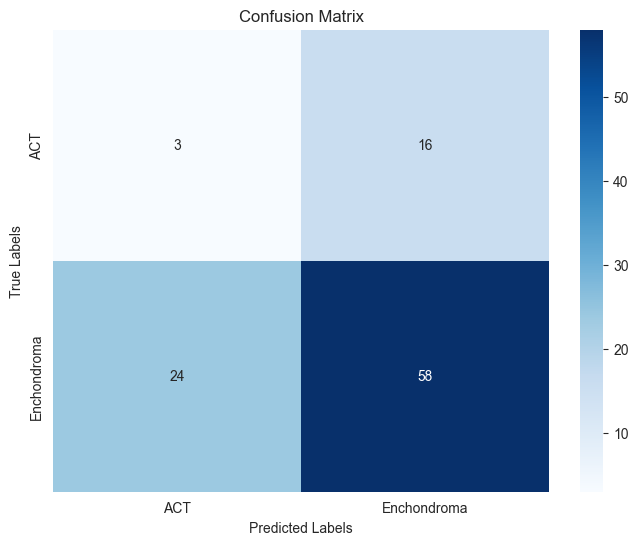

Epoch [25/100], Training Loss: 0.7383, Training Accuracy: 0.5824
Epoch [25/100], Validation Loss: 0.7359, Validation Accuracy: 0.6040
Validation AUC-ROC: 0.4326, Sensitivity: 0.7073, Specificity: 0.1579
F1-Score: 0.7436


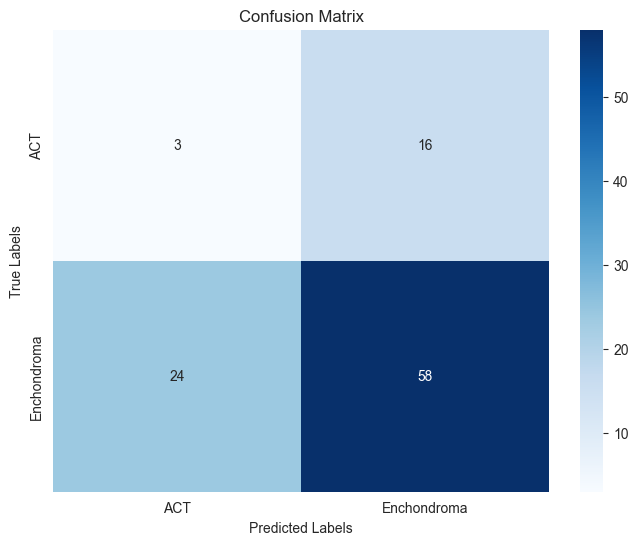

Epoch [26/100], Training Loss: 0.7297, Training Accuracy: 0.5824
Epoch [26/100], Validation Loss: 0.7203, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


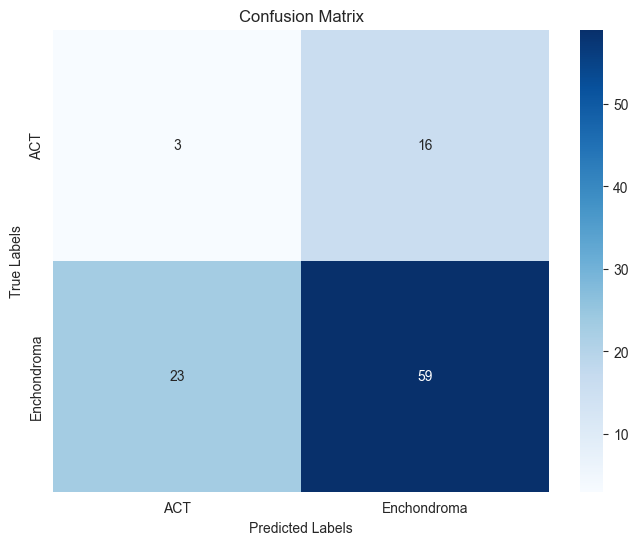

Epoch [27/100], Training Loss: 0.7274, Training Accuracy: 0.5852
Epoch [27/100], Validation Loss: 0.7549, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


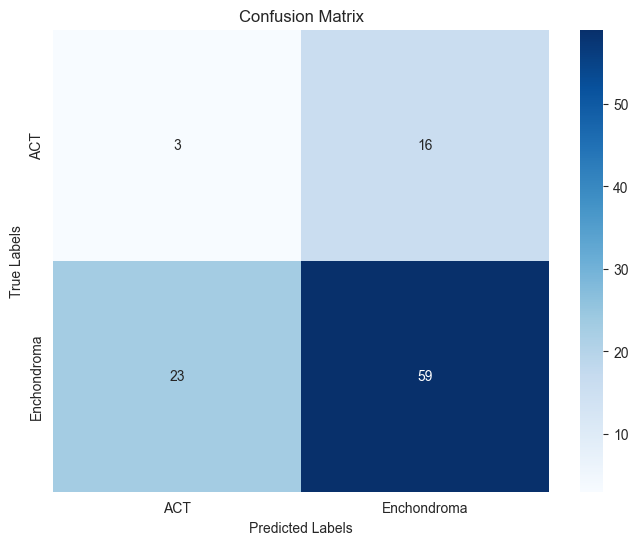

Epoch [28/100], Training Loss: 0.7333, Training Accuracy: 0.5852
Epoch [28/100], Validation Loss: 0.7507, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


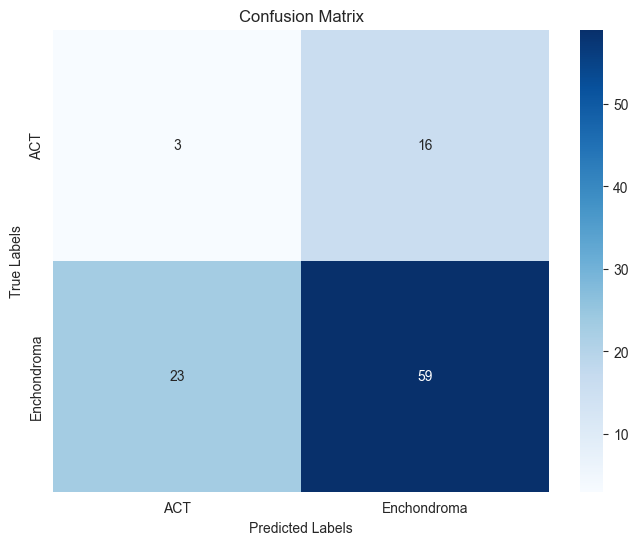

Epoch [29/100], Training Loss: 0.7351, Training Accuracy: 0.5852
Epoch [29/100], Validation Loss: 0.7359, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


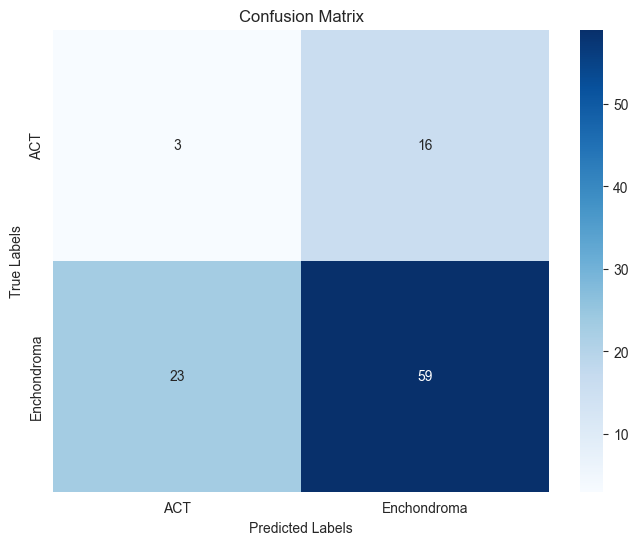

Epoch [30/100], Training Loss: 0.7305, Training Accuracy: 0.5852
Epoch [30/100], Validation Loss: 0.7628, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


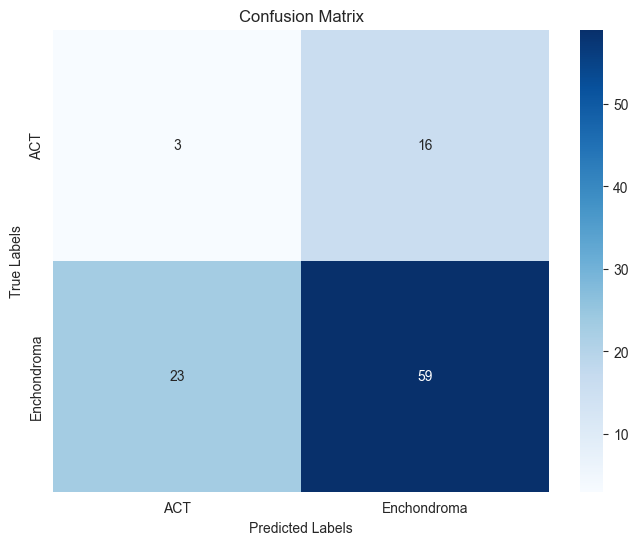

Epoch [31/100], Training Loss: 0.7307, Training Accuracy: 0.5852
Epoch [31/100], Validation Loss: 0.7400, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


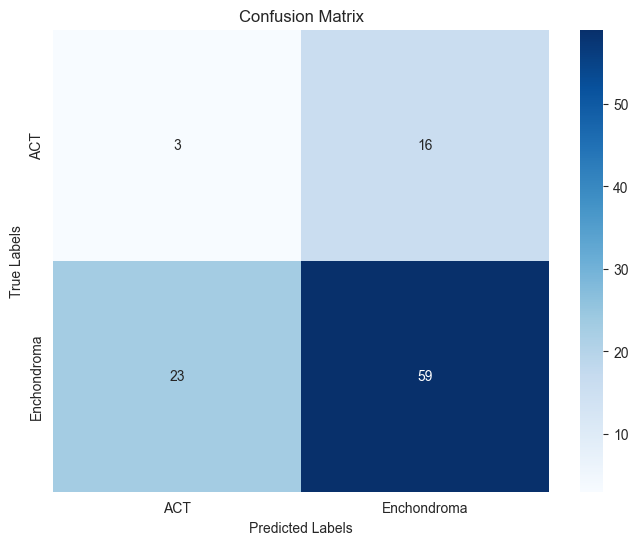

Epoch [32/100], Training Loss: 0.7314, Training Accuracy: 0.5852
Epoch [32/100], Validation Loss: 0.7387, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


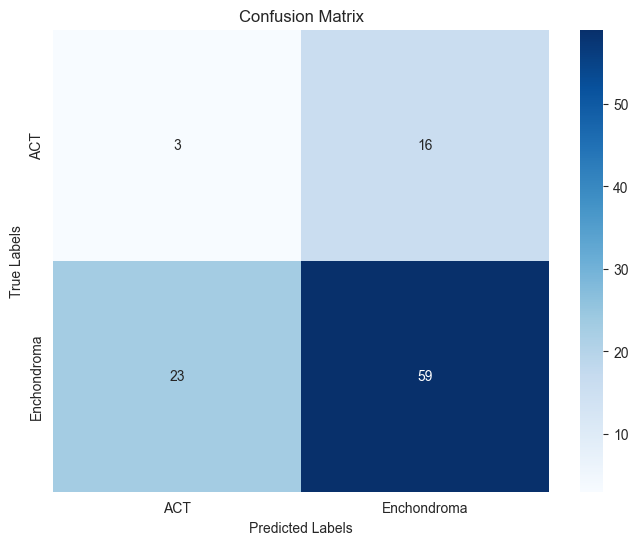

Epoch [33/100], Training Loss: 0.7412, Training Accuracy: 0.5852
Epoch [33/100], Validation Loss: 0.7435, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


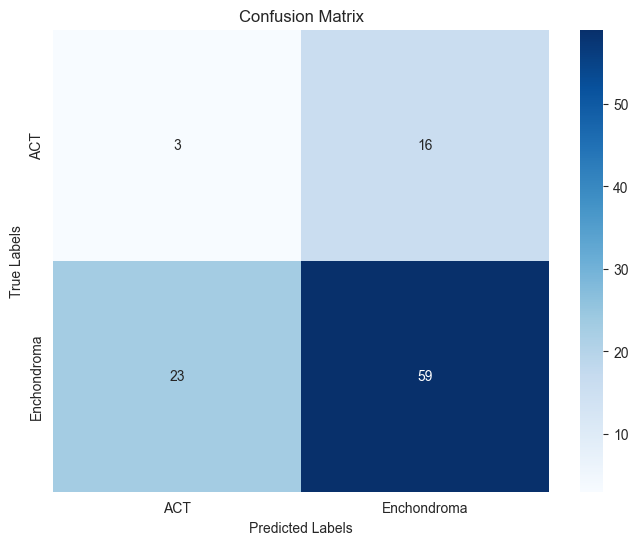

Epoch [34/100], Training Loss: 0.7336, Training Accuracy: 0.5852
Epoch [34/100], Validation Loss: 0.7469, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


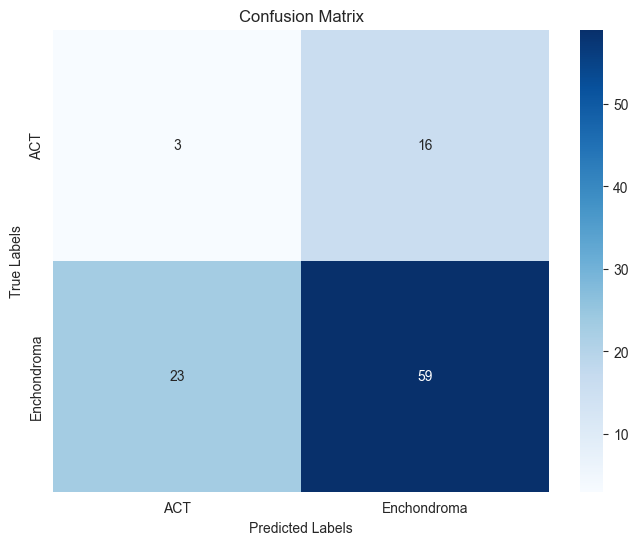

Epoch [35/100], Training Loss: 0.7343, Training Accuracy: 0.5852
Epoch [35/100], Validation Loss: 0.7441, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


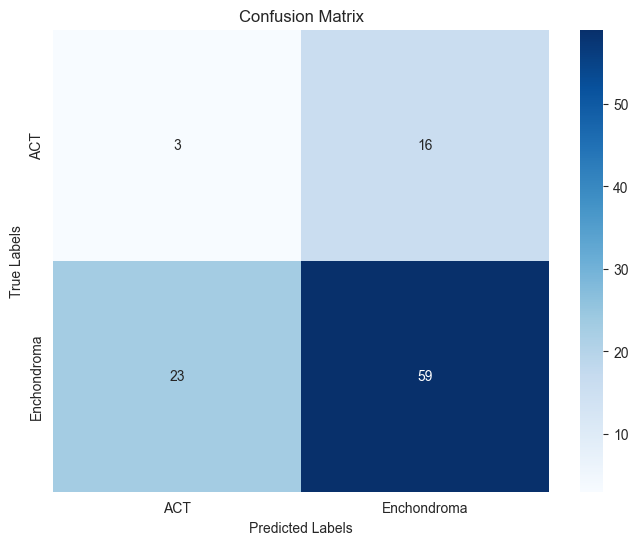

Epoch [36/100], Training Loss: 0.7359, Training Accuracy: 0.5852
Epoch [36/100], Validation Loss: 0.7371, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


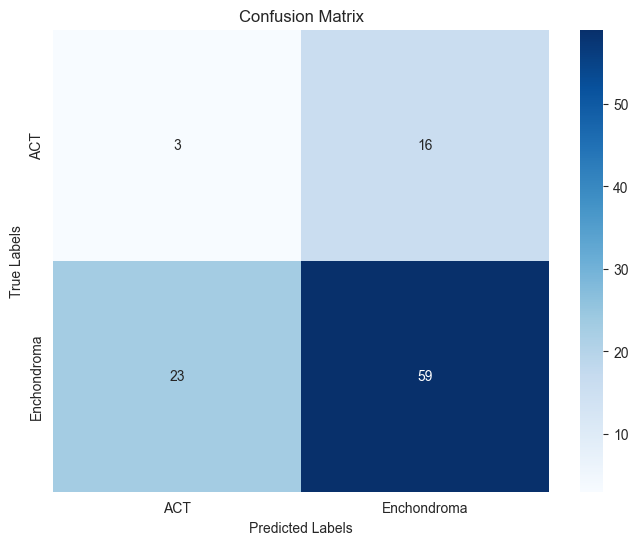

Epoch [37/100], Training Loss: 0.7267, Training Accuracy: 0.5852
Epoch [37/100], Validation Loss: 0.7394, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


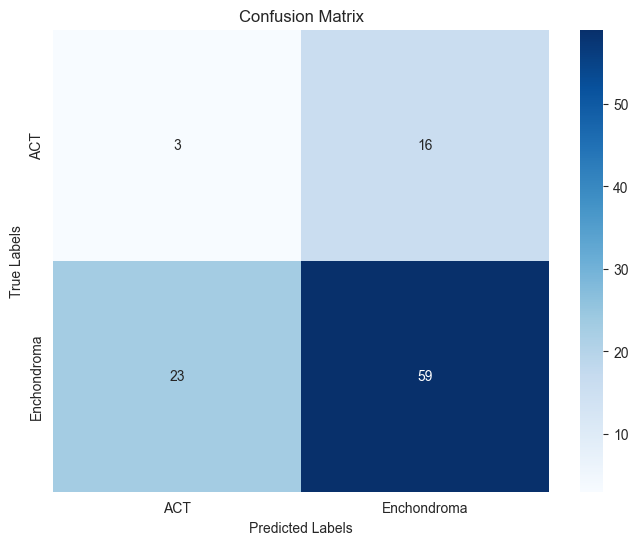

Epoch [38/100], Training Loss: 0.7285, Training Accuracy: 0.5852
Epoch [38/100], Validation Loss: 0.7677, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


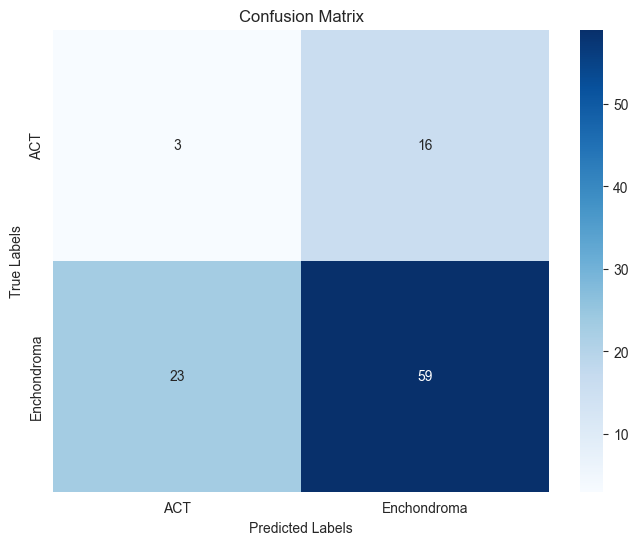

Epoch [39/100], Training Loss: 0.7352, Training Accuracy: 0.5852
Epoch [39/100], Validation Loss: 0.7237, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


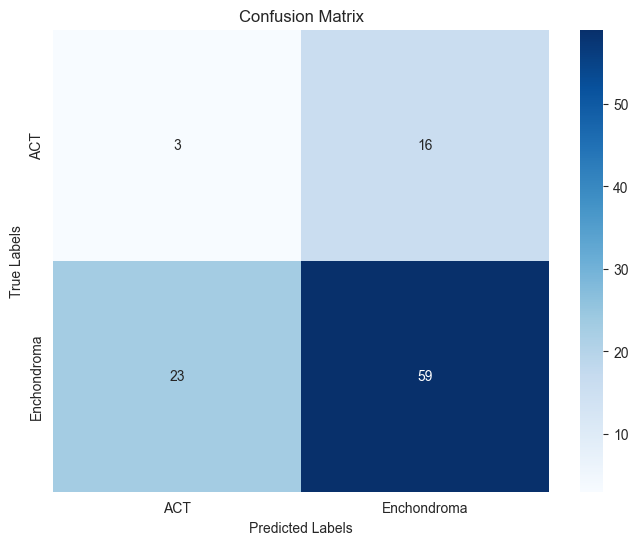

Epoch [40/100], Training Loss: 0.7268, Training Accuracy: 0.5852
Epoch [40/100], Validation Loss: 0.7609, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


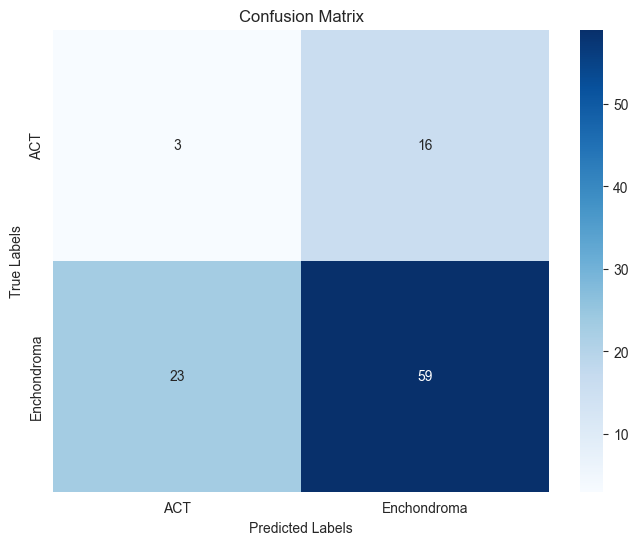

Epoch [41/100], Training Loss: 0.7185, Training Accuracy: 0.5852
Epoch [41/100], Validation Loss: 0.7392, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


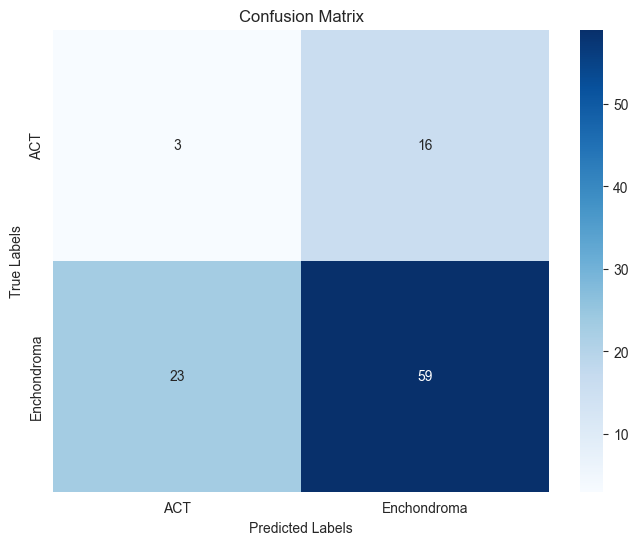

Epoch [42/100], Training Loss: 0.7219, Training Accuracy: 0.5852
Epoch [42/100], Validation Loss: 0.7546, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


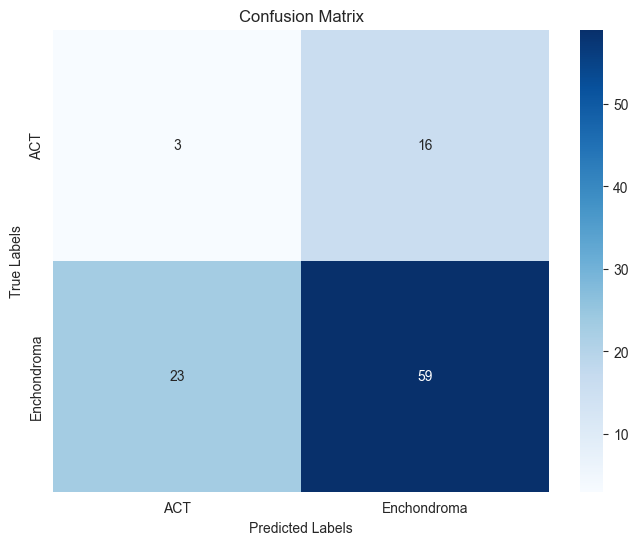

Epoch [43/100], Training Loss: 0.7352, Training Accuracy: 0.5852
Epoch [43/100], Validation Loss: 0.7510, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


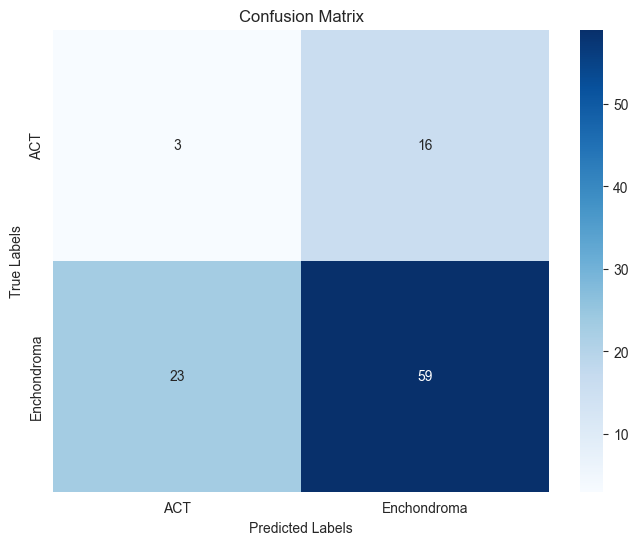

Epoch [44/100], Training Loss: 0.7288, Training Accuracy: 0.5852
Epoch [44/100], Validation Loss: 0.7377, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


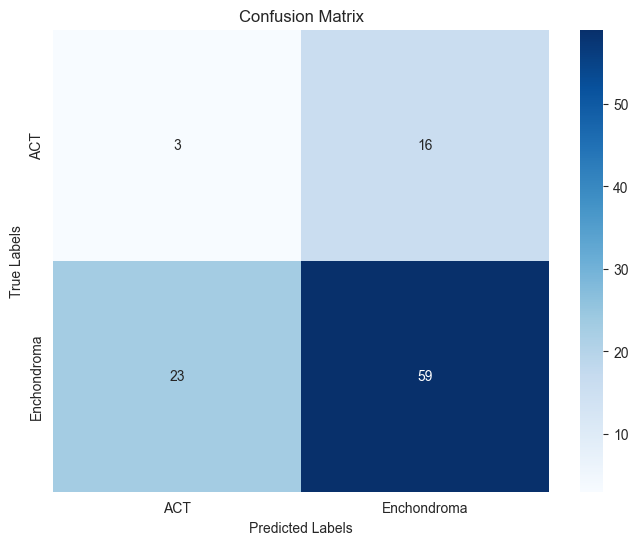

Epoch [45/100], Training Loss: 0.7305, Training Accuracy: 0.5852
Epoch [45/100], Validation Loss: 0.7493, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


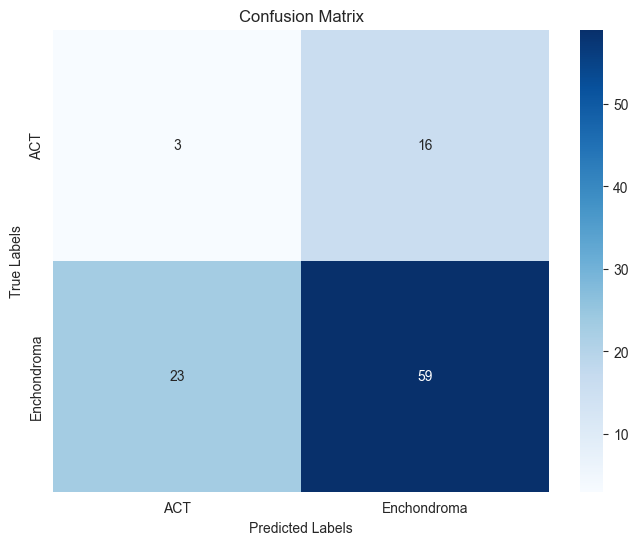

Epoch [46/100], Training Loss: 0.7281, Training Accuracy: 0.5852
Epoch [46/100], Validation Loss: 0.7453, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


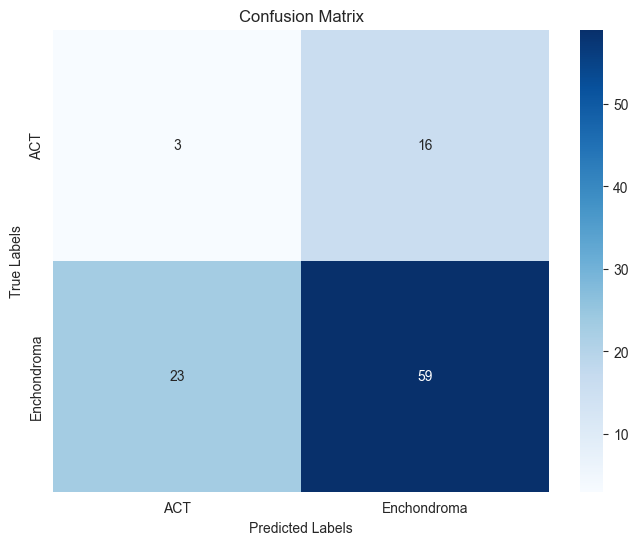

Epoch [47/100], Training Loss: 0.7299, Training Accuracy: 0.5852
Epoch [47/100], Validation Loss: 0.7480, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


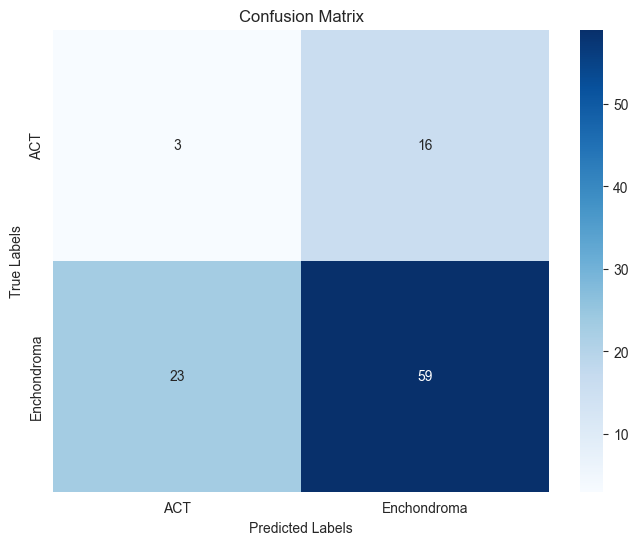

Epoch [48/100], Training Loss: 0.7411, Training Accuracy: 0.5852
Epoch [48/100], Validation Loss: 0.7173, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


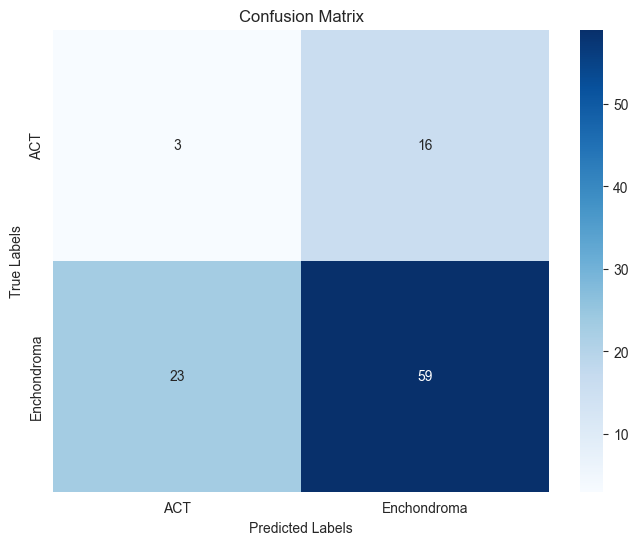

Epoch [49/100], Training Loss: 0.7252, Training Accuracy: 0.5852
Epoch [49/100], Validation Loss: 0.7419, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


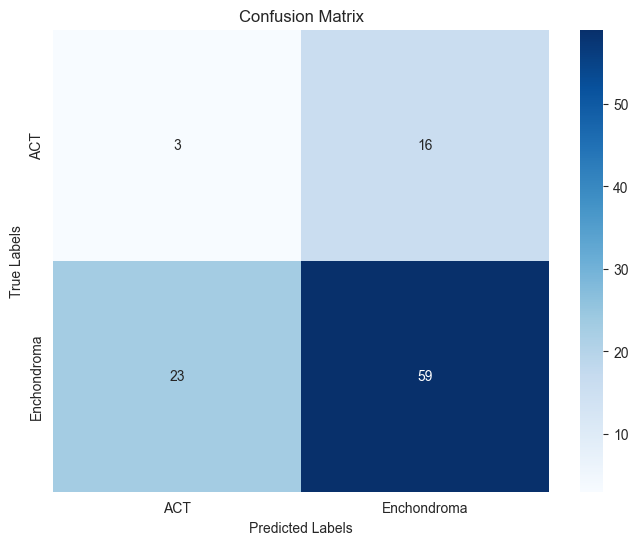

Epoch [50/100], Training Loss: 0.7289, Training Accuracy: 0.5852
Epoch [50/100], Validation Loss: 0.7276, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


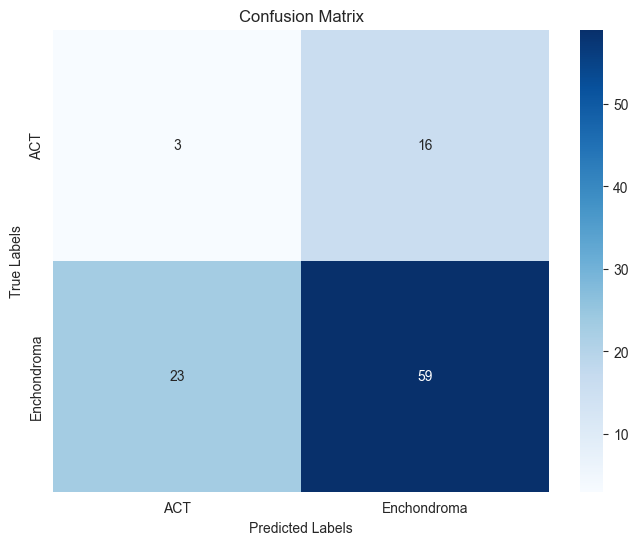

Epoch [51/100], Training Loss: 0.7316, Training Accuracy: 0.5852
Epoch [51/100], Validation Loss: 0.7520, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


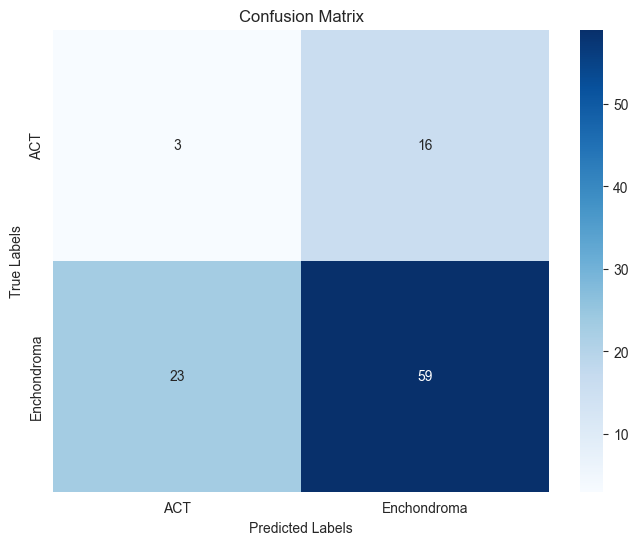

Epoch [52/100], Training Loss: 0.7306, Training Accuracy: 0.5852
Epoch [52/100], Validation Loss: 0.7506, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


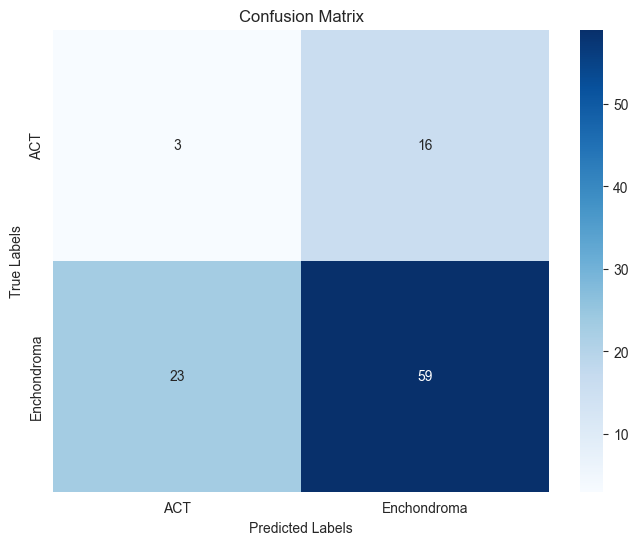

Epoch [53/100], Training Loss: 0.7303, Training Accuracy: 0.5852
Epoch [53/100], Validation Loss: 0.7333, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


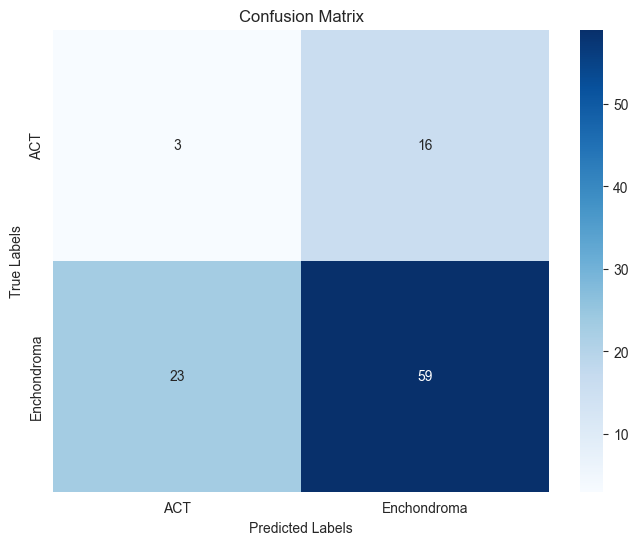

Epoch [54/100], Training Loss: 0.7243, Training Accuracy: 0.5852
Epoch [54/100], Validation Loss: 0.7558, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


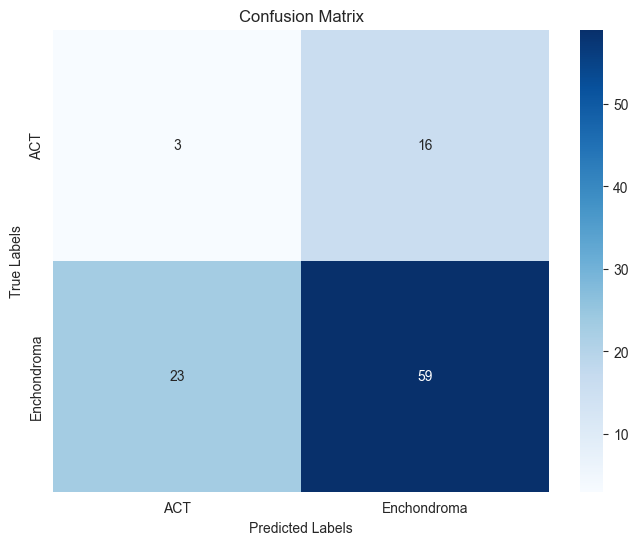

Epoch [55/100], Training Loss: 0.7362, Training Accuracy: 0.5852
Epoch [55/100], Validation Loss: 0.7267, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


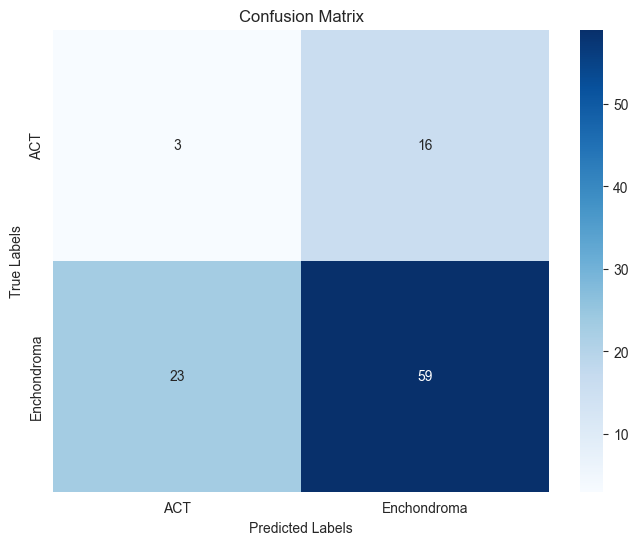

Epoch [56/100], Training Loss: 0.7259, Training Accuracy: 0.5852
Epoch [56/100], Validation Loss: 0.7451, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


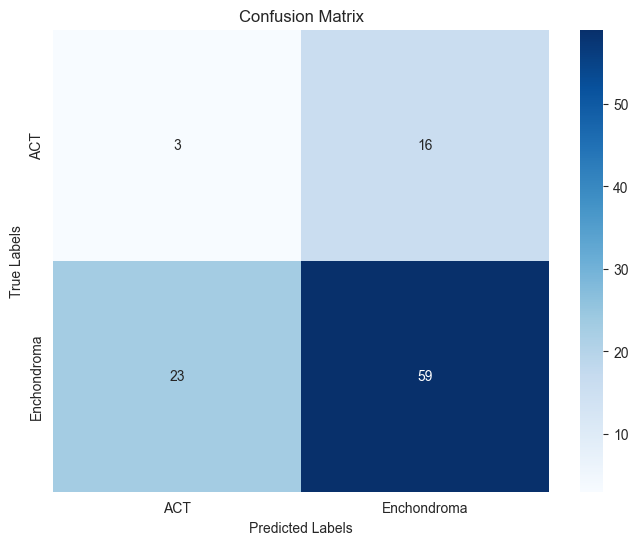

Epoch [57/100], Training Loss: 0.7278, Training Accuracy: 0.5852
Epoch [57/100], Validation Loss: 0.7479, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


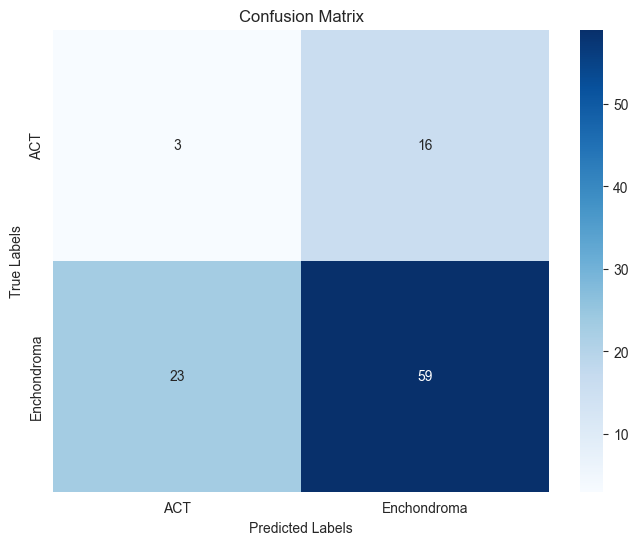

Epoch [58/100], Training Loss: 0.7433, Training Accuracy: 0.5852
Epoch [58/100], Validation Loss: 0.7334, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


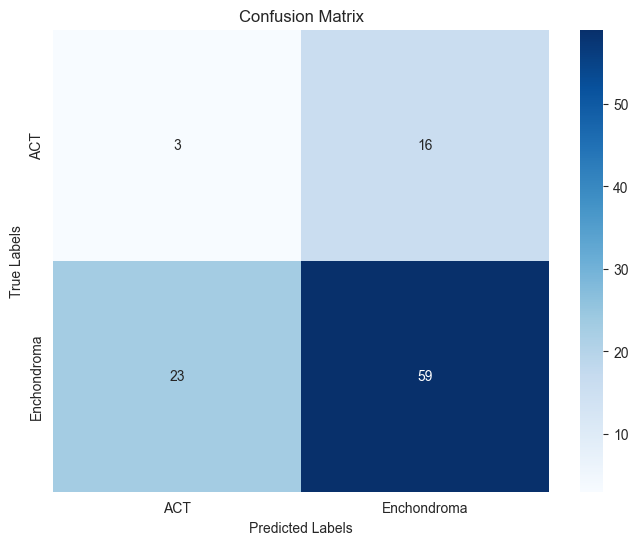

Epoch [59/100], Training Loss: 0.7345, Training Accuracy: 0.5824
Epoch [59/100], Validation Loss: 0.7414, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


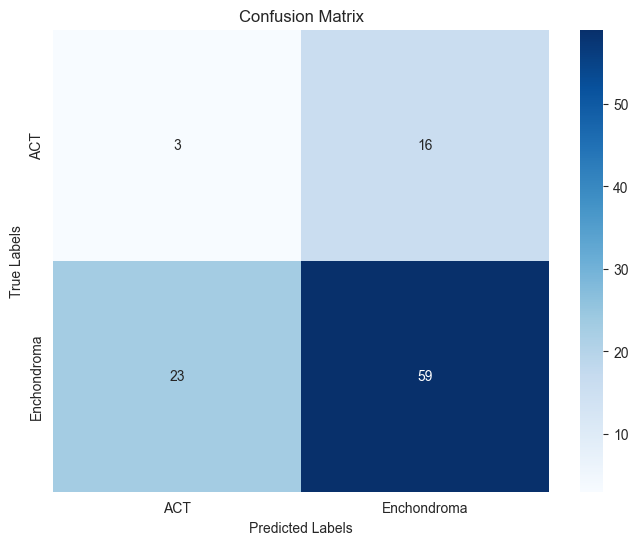

Epoch [60/100], Training Loss: 0.7314, Training Accuracy: 0.5852
Epoch [60/100], Validation Loss: 0.7508, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


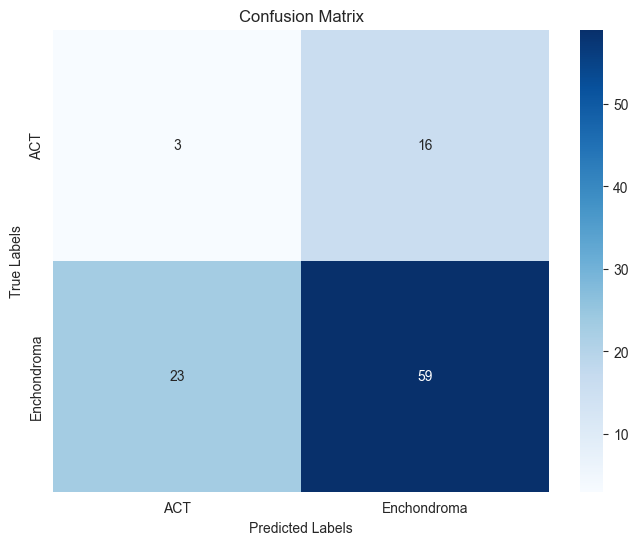

Epoch [61/100], Training Loss: 0.7240, Training Accuracy: 0.5852
Epoch [61/100], Validation Loss: 0.7296, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


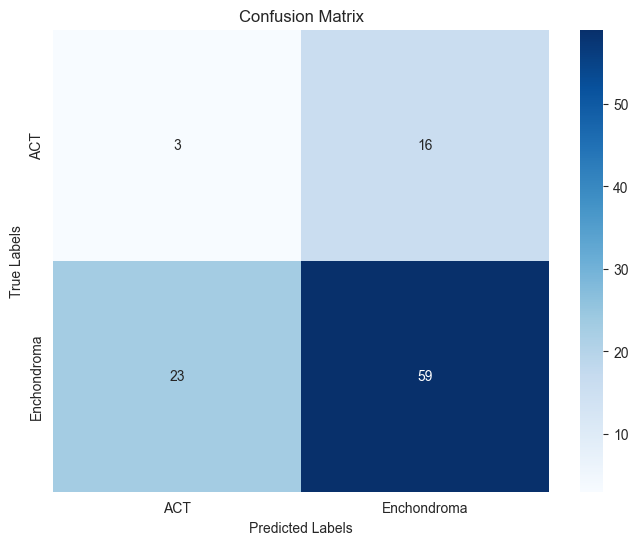

Epoch [62/100], Training Loss: 0.7331, Training Accuracy: 0.5852
Epoch [62/100], Validation Loss: 0.7440, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


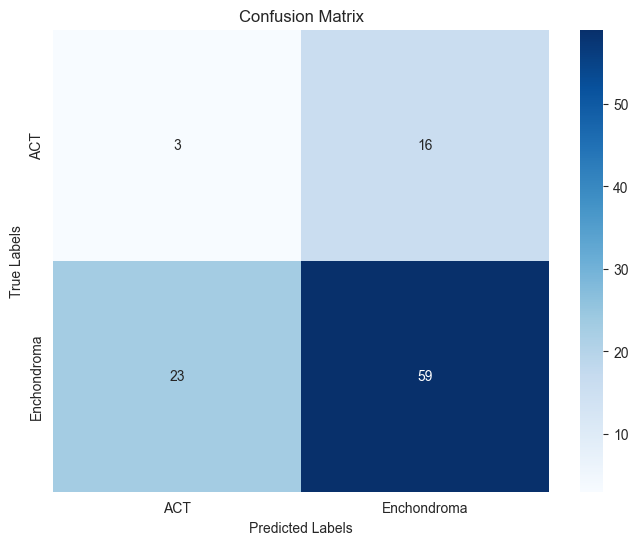

Epoch [63/100], Training Loss: 0.7148, Training Accuracy: 0.5852
Epoch [63/100], Validation Loss: 0.7482, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


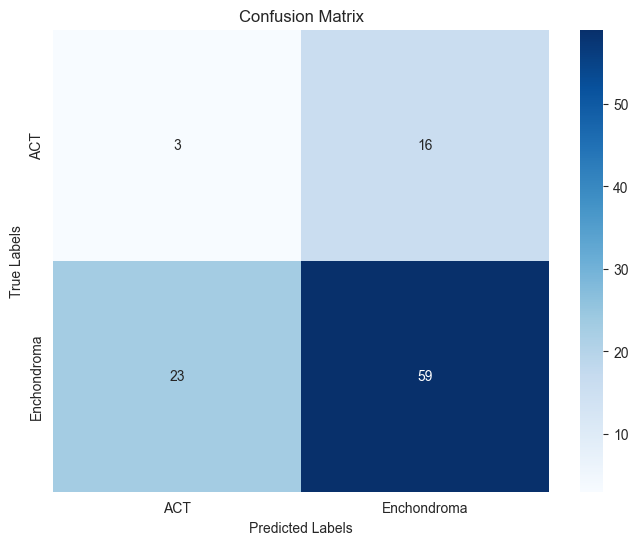

Epoch [64/100], Training Loss: 0.7269, Training Accuracy: 0.5852
Epoch [64/100], Validation Loss: 0.7502, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


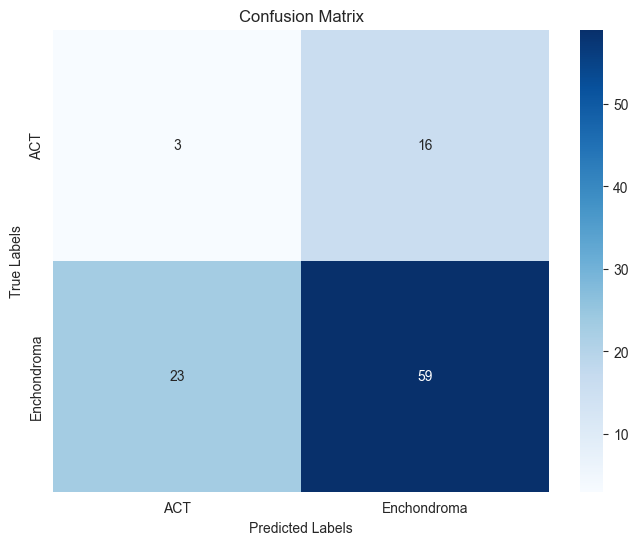

Epoch [65/100], Training Loss: 0.7309, Training Accuracy: 0.5852
Epoch [65/100], Validation Loss: 0.7486, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


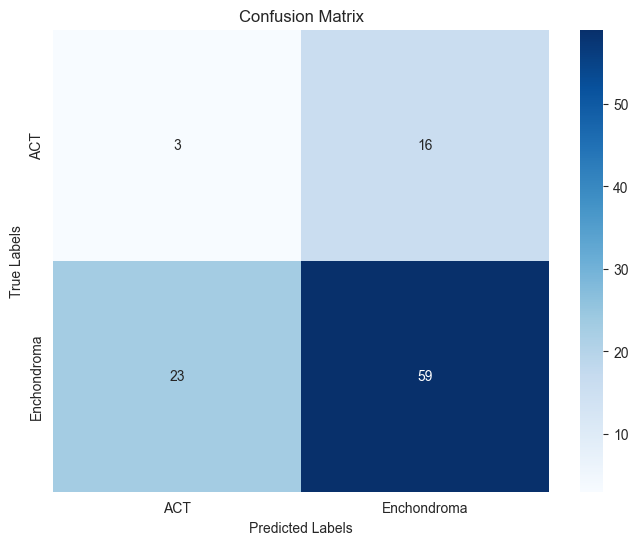

Epoch [66/100], Training Loss: 0.7296, Training Accuracy: 0.5852
Epoch [66/100], Validation Loss: 0.7421, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


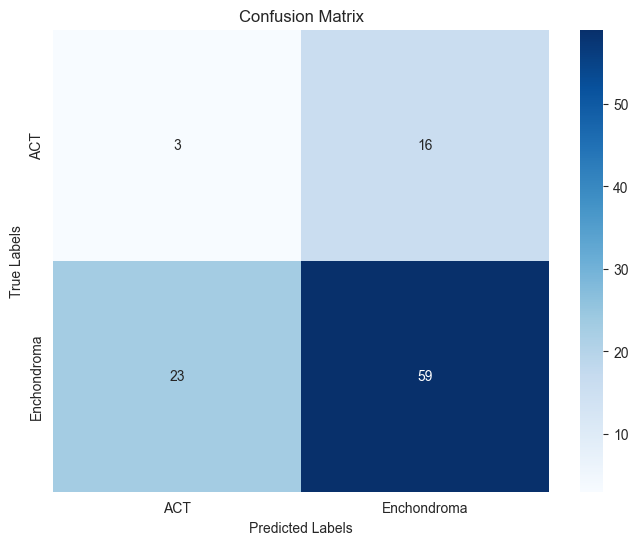

Epoch [67/100], Training Loss: 0.7266, Training Accuracy: 0.5852
Epoch [67/100], Validation Loss: 0.7188, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


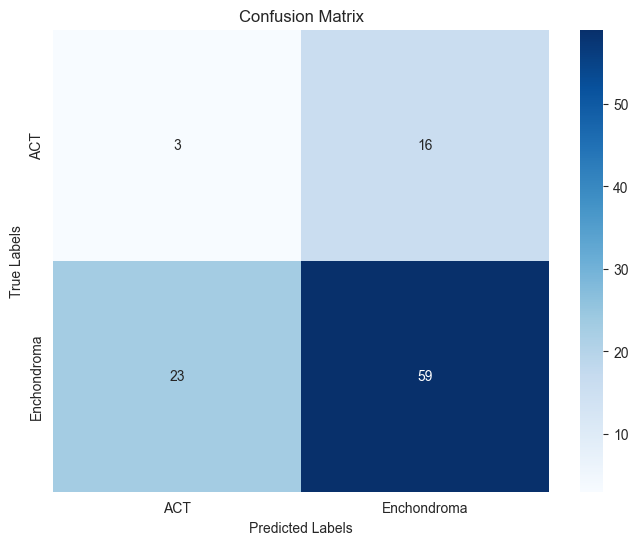

Epoch [68/100], Training Loss: 0.7264, Training Accuracy: 0.5852
Epoch [68/100], Validation Loss: 0.7415, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


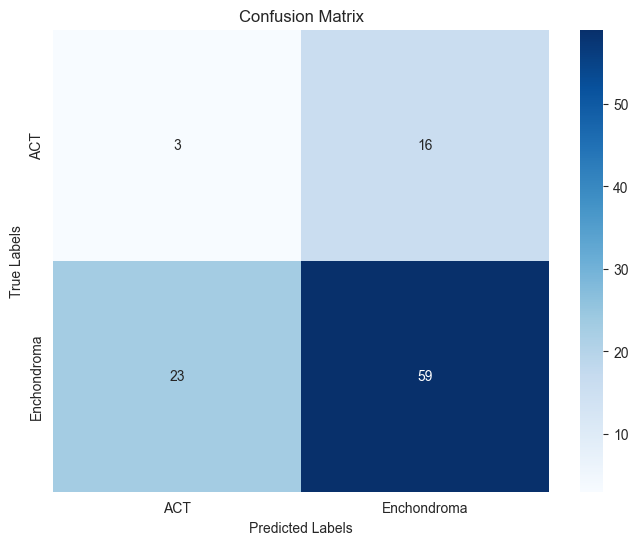

Epoch [69/100], Training Loss: 0.7431, Training Accuracy: 0.5852
Epoch [69/100], Validation Loss: 0.7188, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


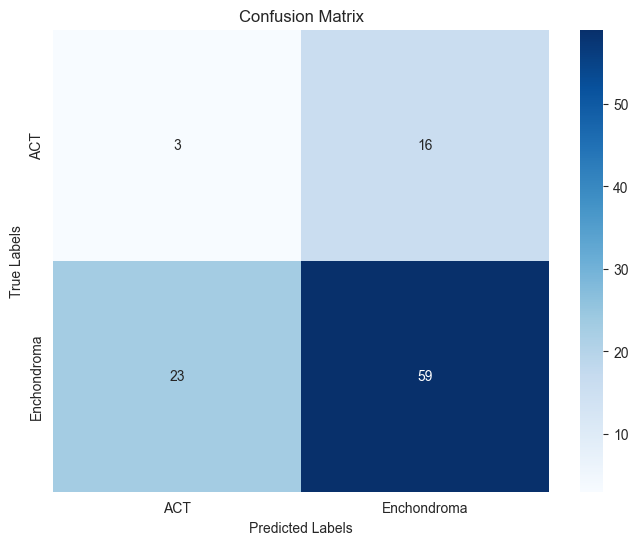

Epoch [70/100], Training Loss: 0.7222, Training Accuracy: 0.5852
Epoch [70/100], Validation Loss: 0.7193, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


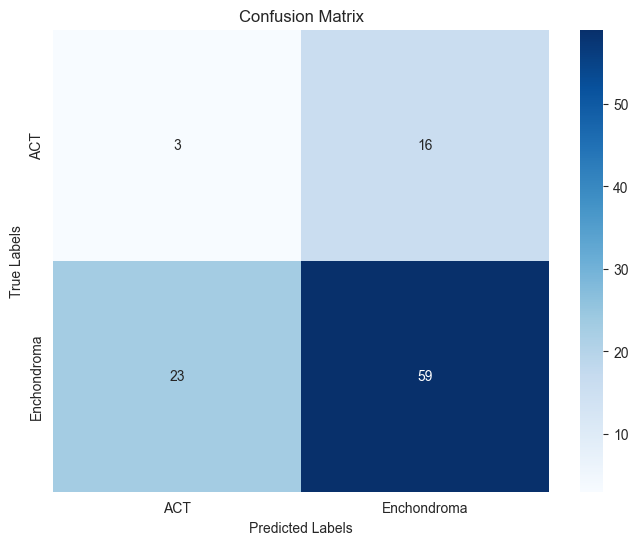

Epoch [71/100], Training Loss: 0.7236, Training Accuracy: 0.5852
Epoch [71/100], Validation Loss: 0.7388, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


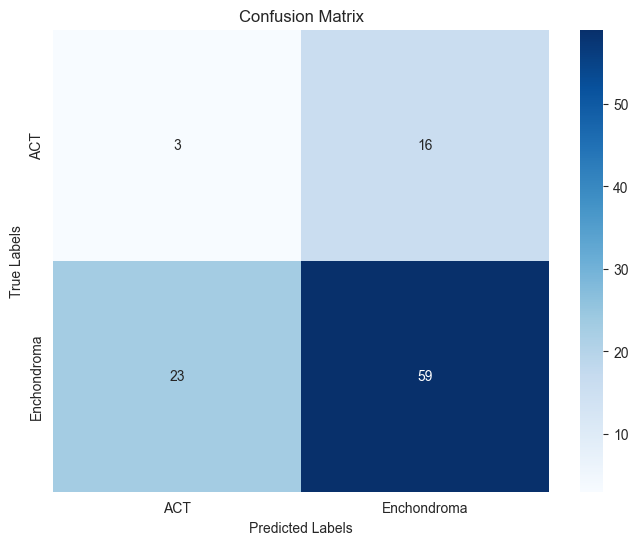

Epoch [72/100], Training Loss: 0.7336, Training Accuracy: 0.5852
Epoch [72/100], Validation Loss: 0.7246, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


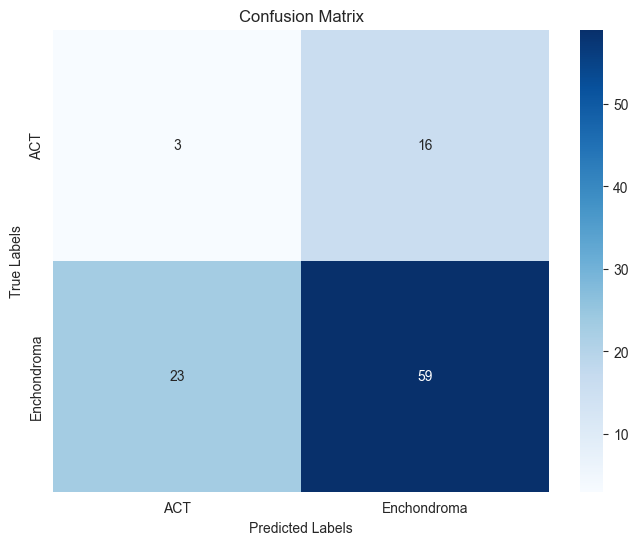

Epoch [73/100], Training Loss: 0.7229, Training Accuracy: 0.5852
Epoch [73/100], Validation Loss: 0.7333, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


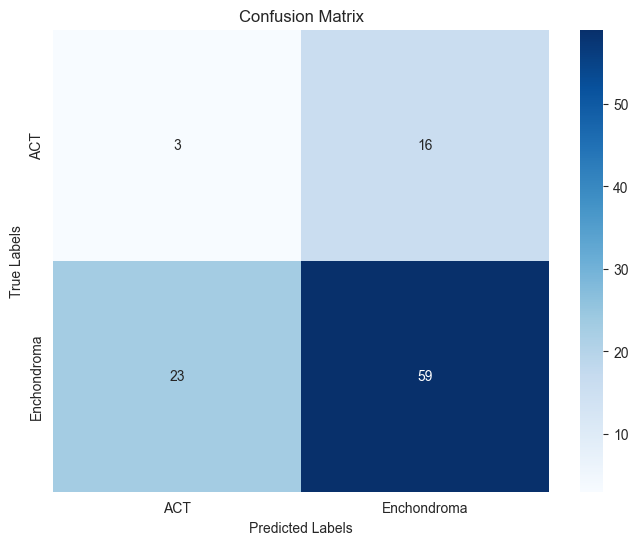

Epoch [74/100], Training Loss: 0.7319, Training Accuracy: 0.5852
Epoch [74/100], Validation Loss: 0.7271, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


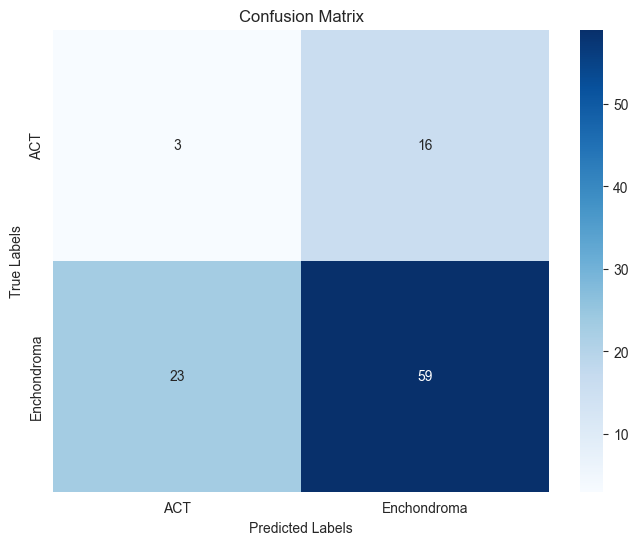

Epoch [75/100], Training Loss: 0.7335, Training Accuracy: 0.5852
Epoch [75/100], Validation Loss: 0.7594, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


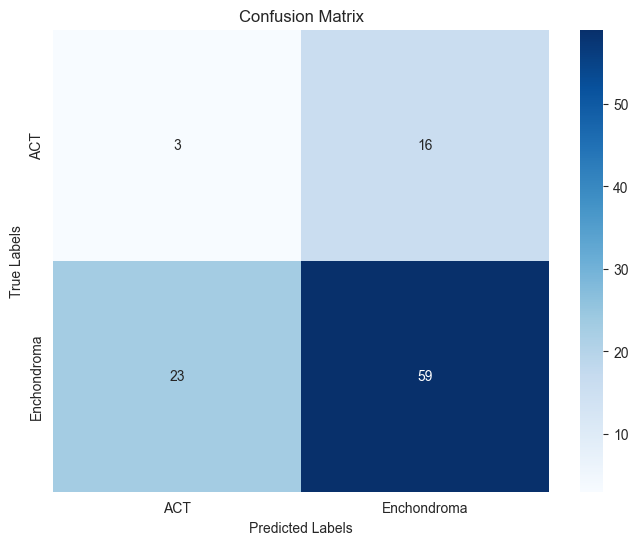

Epoch [76/100], Training Loss: 0.7327, Training Accuracy: 0.5852
Epoch [76/100], Validation Loss: 0.7484, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


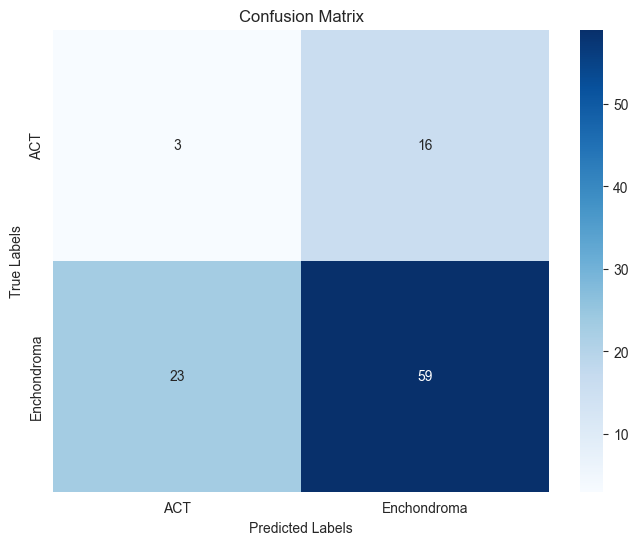

Epoch [77/100], Training Loss: 0.7262, Training Accuracy: 0.5852
Epoch [77/100], Validation Loss: 0.7163, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


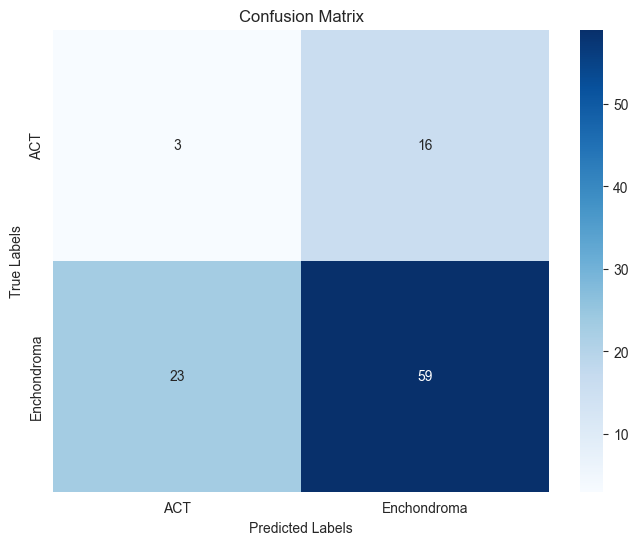

Epoch [78/100], Training Loss: 0.7309, Training Accuracy: 0.5852
Epoch [78/100], Validation Loss: 0.7248, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


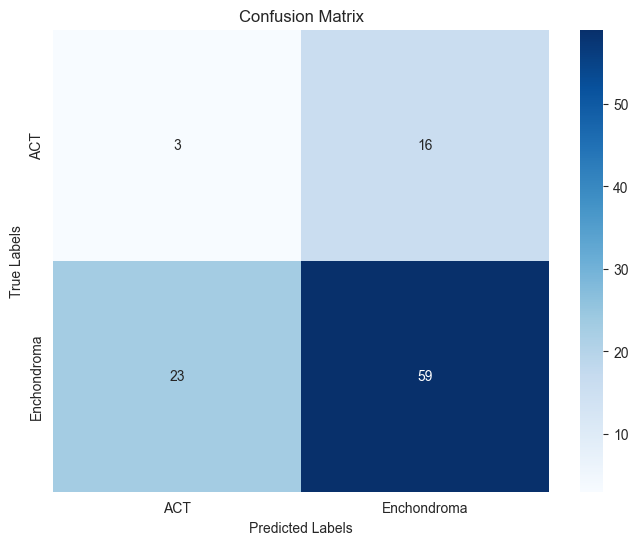

Epoch [79/100], Training Loss: 0.7255, Training Accuracy: 0.5852
Epoch [79/100], Validation Loss: 0.7520, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


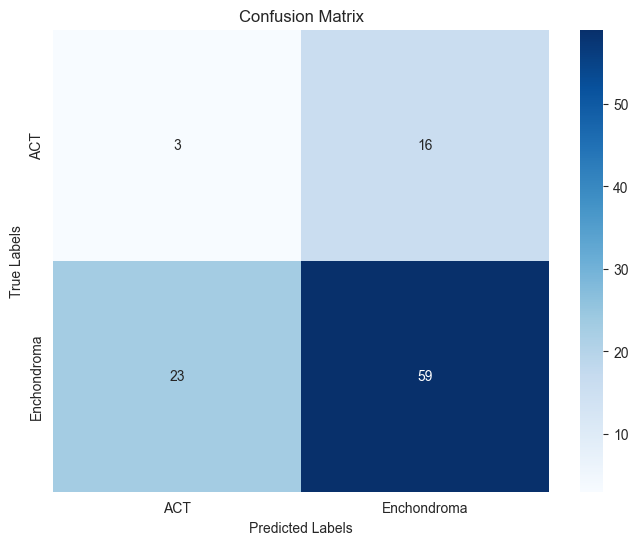

Epoch [80/100], Training Loss: 0.7273, Training Accuracy: 0.5852
Epoch [80/100], Validation Loss: 0.7440, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


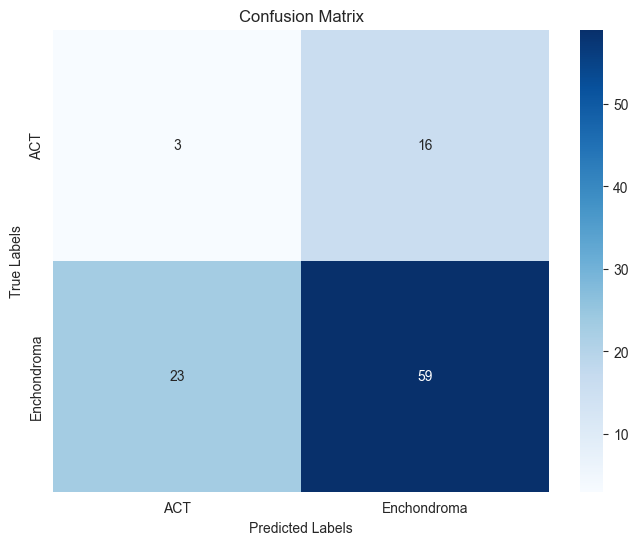

Epoch [81/100], Training Loss: 0.7292, Training Accuracy: 0.5852
Epoch [81/100], Validation Loss: 0.7305, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


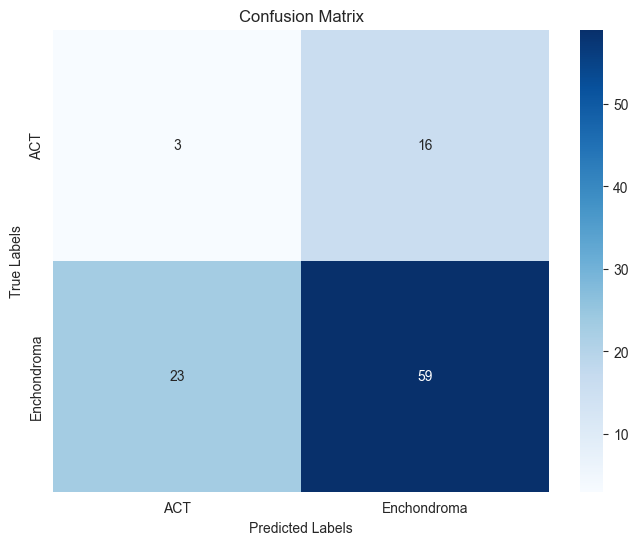

Epoch [82/100], Training Loss: 0.7221, Training Accuracy: 0.5852
Epoch [82/100], Validation Loss: 0.7404, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


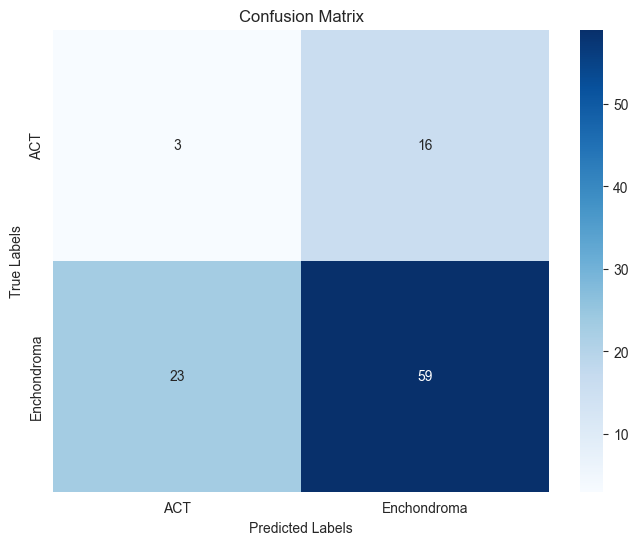

Epoch [83/100], Training Loss: 0.7151, Training Accuracy: 0.5852
Epoch [83/100], Validation Loss: 0.7253, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


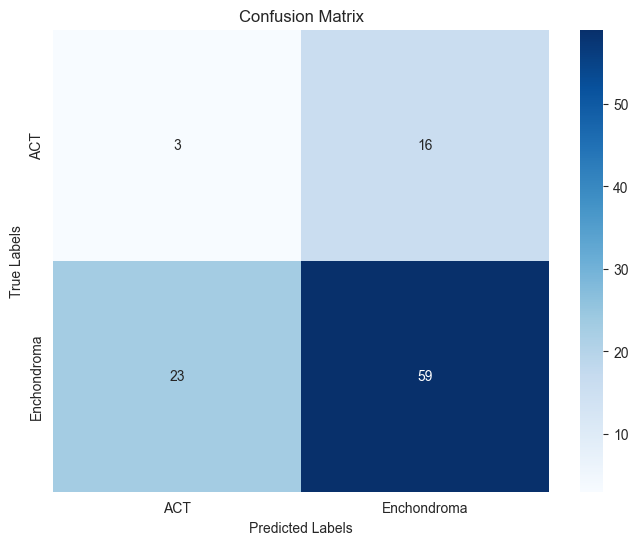

Epoch [84/100], Training Loss: 0.7308, Training Accuracy: 0.5852
Epoch [84/100], Validation Loss: 0.7355, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


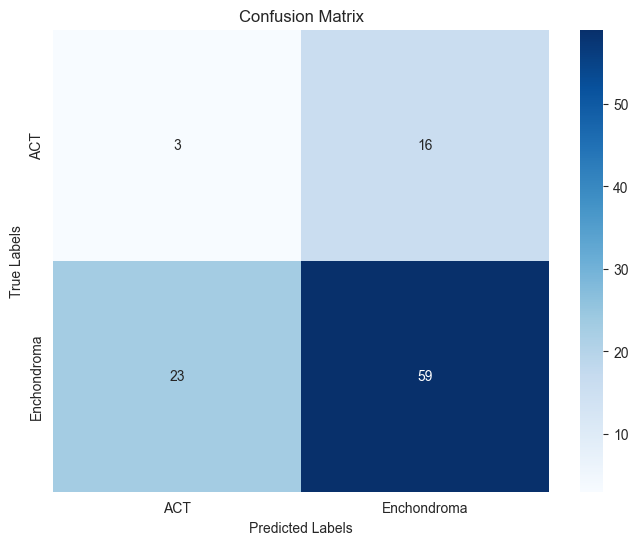

Epoch [85/100], Training Loss: 0.7299, Training Accuracy: 0.5852
Epoch [85/100], Validation Loss: 0.7132, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


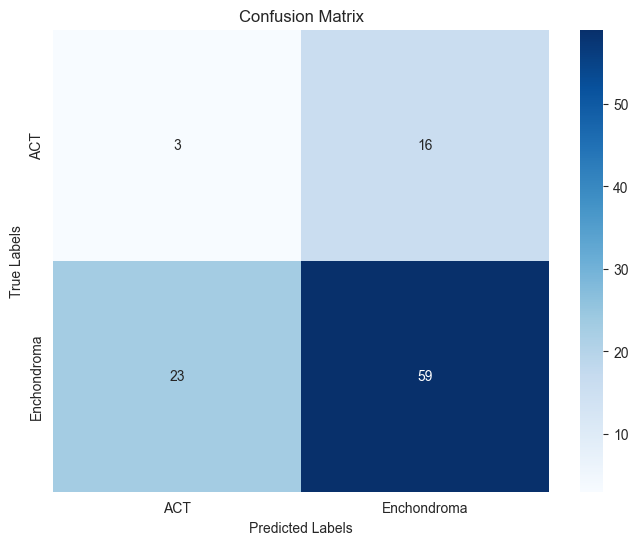

Epoch [86/100], Training Loss: 0.7283, Training Accuracy: 0.5852
Epoch [86/100], Validation Loss: 0.7246, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


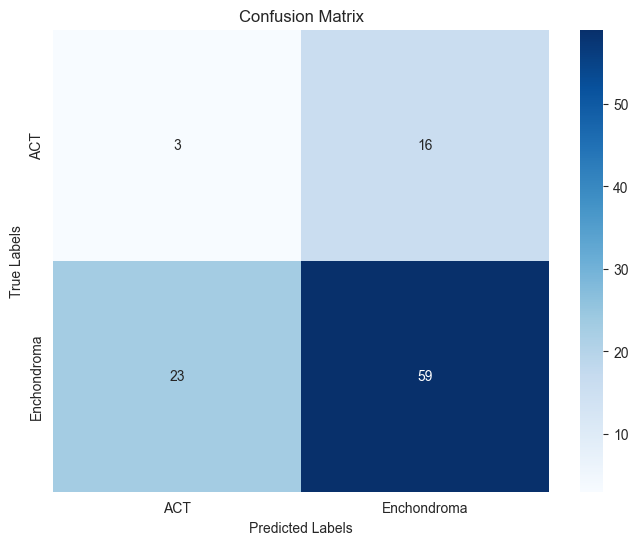

Epoch [87/100], Training Loss: 0.7226, Training Accuracy: 0.5852
Epoch [87/100], Validation Loss: 0.7133, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


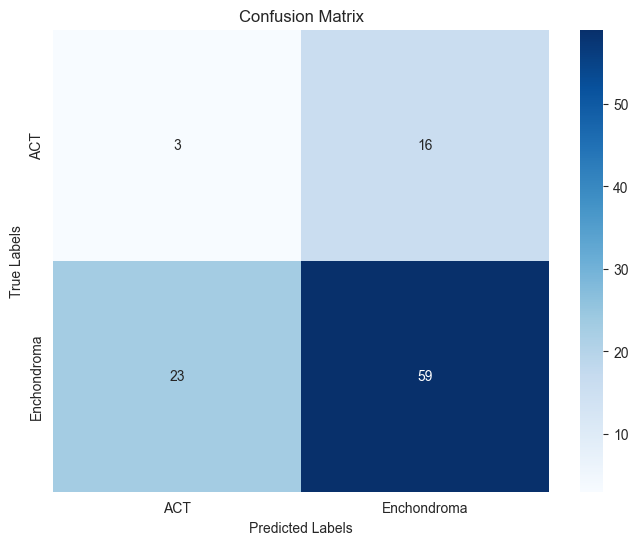

Epoch [88/100], Training Loss: 0.7282, Training Accuracy: 0.5852
Epoch [88/100], Validation Loss: 0.7345, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


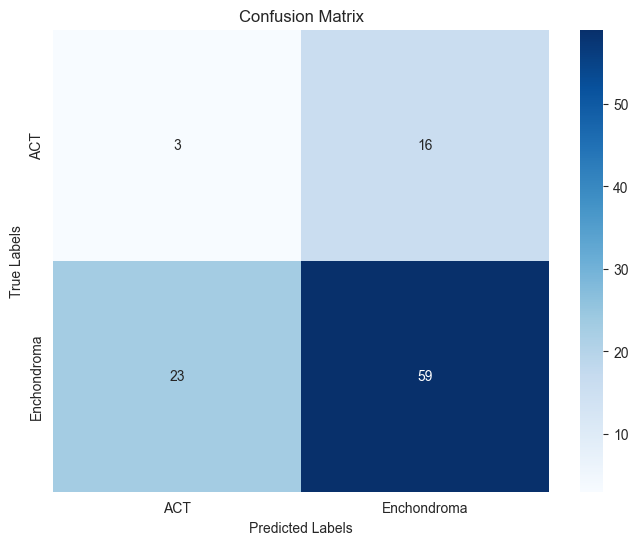

Epoch [89/100], Training Loss: 0.7389, Training Accuracy: 0.5852
Epoch [89/100], Validation Loss: 0.7329, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


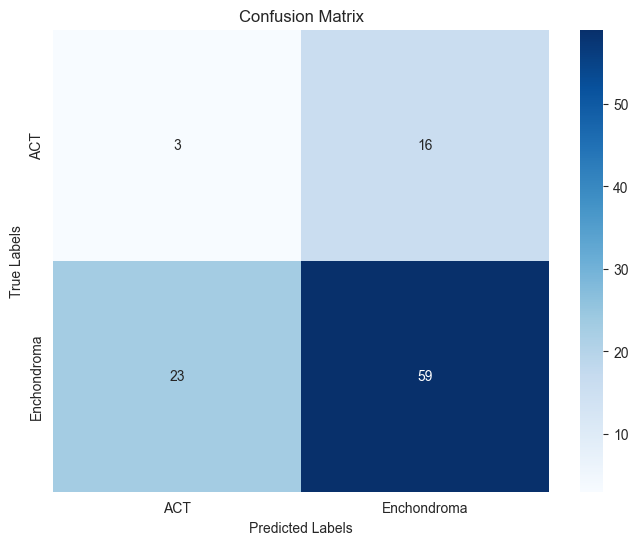

Epoch [90/100], Training Loss: 0.7383, Training Accuracy: 0.5852
Epoch [90/100], Validation Loss: 0.7174, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


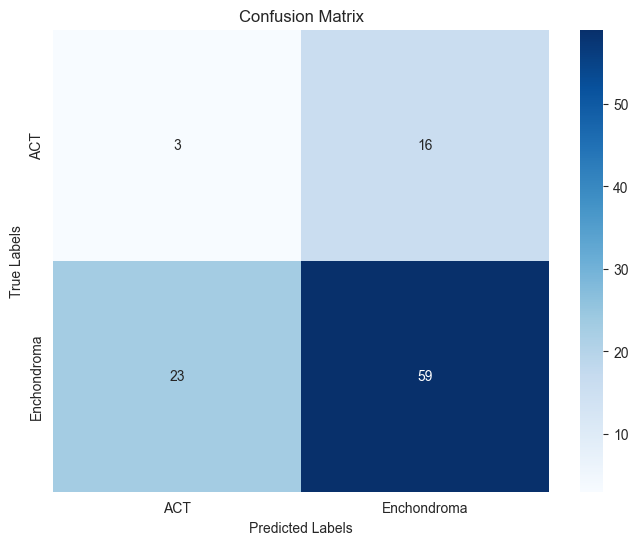

Epoch [91/100], Training Loss: 0.7299, Training Accuracy: 0.5852
Epoch [91/100], Validation Loss: 0.7382, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


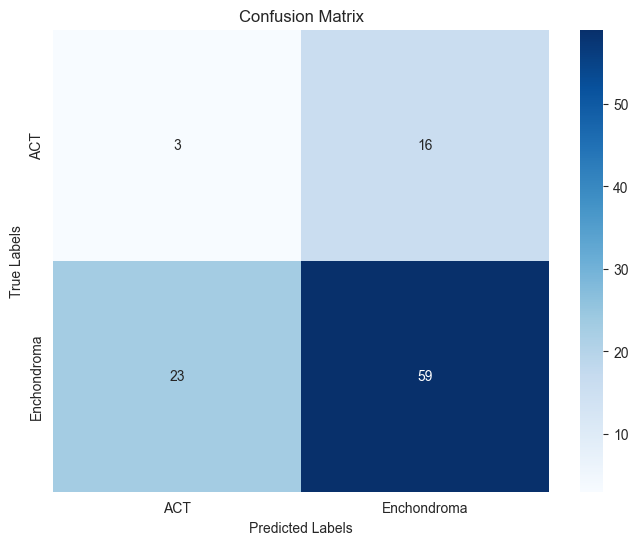

Epoch [92/100], Training Loss: 0.7327, Training Accuracy: 0.5852
Epoch [92/100], Validation Loss: 0.7490, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


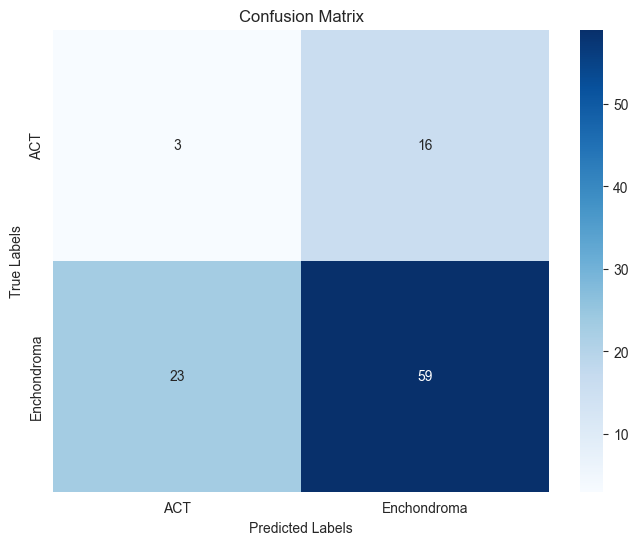

Epoch [93/100], Training Loss: 0.7331, Training Accuracy: 0.5852
Epoch [93/100], Validation Loss: 0.7543, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


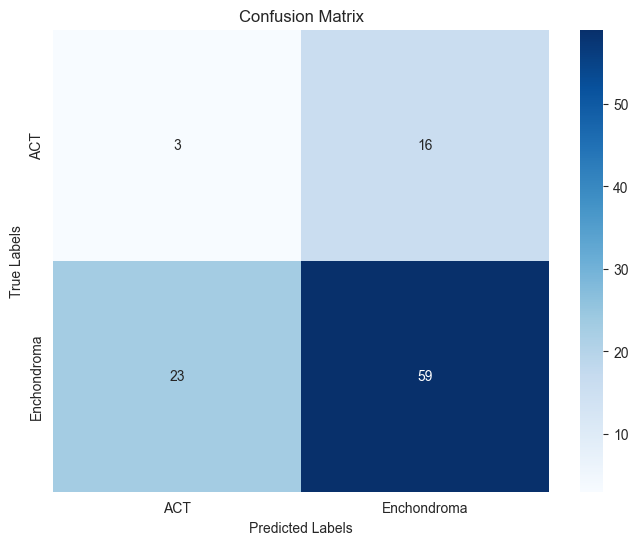

Epoch [94/100], Training Loss: 0.7229, Training Accuracy: 0.5852
Epoch [94/100], Validation Loss: 0.7153, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


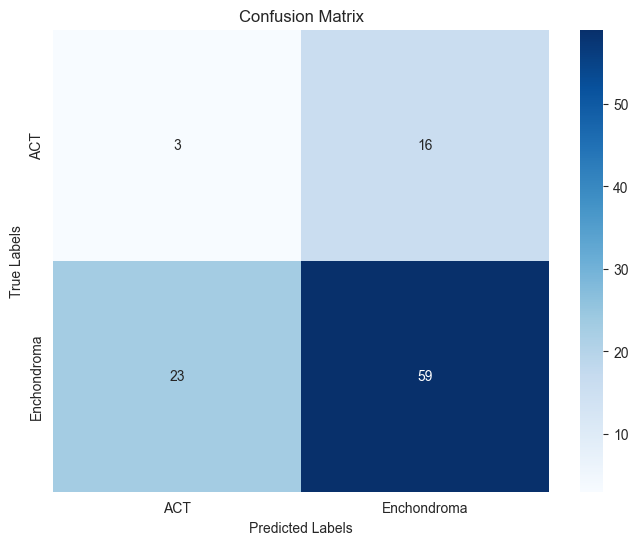

Epoch [95/100], Training Loss: 0.7210, Training Accuracy: 0.5852
Epoch [95/100], Validation Loss: 0.7505, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


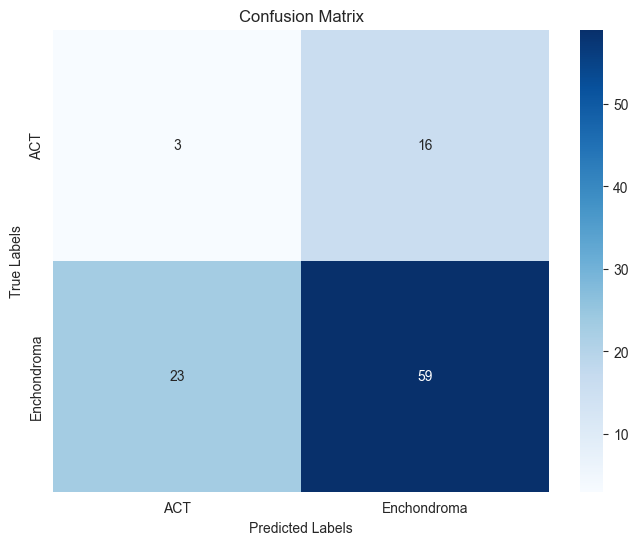

Epoch [96/100], Training Loss: 0.7359, Training Accuracy: 0.5852
Epoch [96/100], Validation Loss: 0.7462, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


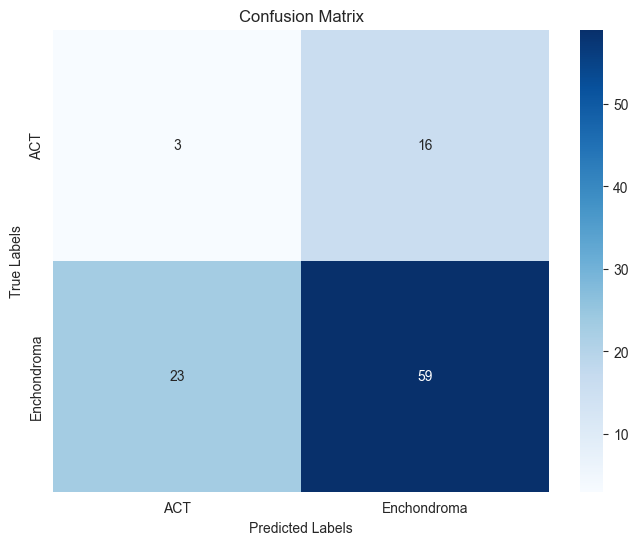

Epoch [97/100], Training Loss: 0.7272, Training Accuracy: 0.5852
Epoch [97/100], Validation Loss: 0.7447, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


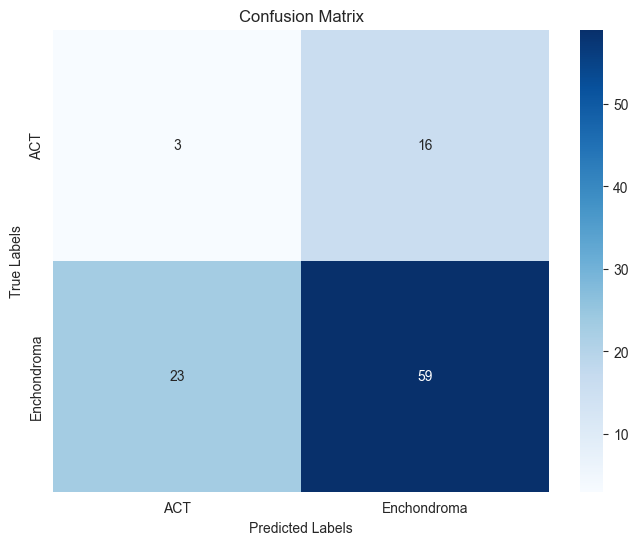

Epoch [98/100], Training Loss: 0.7317, Training Accuracy: 0.5852
Epoch [98/100], Validation Loss: 0.7625, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


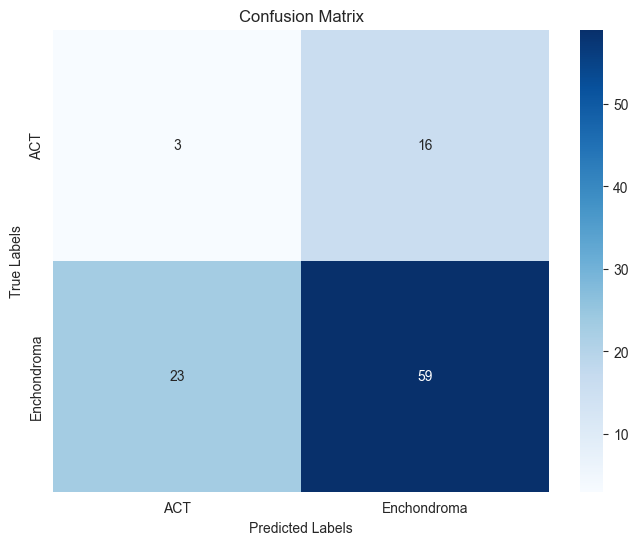

Epoch [99/100], Training Loss: 0.7304, Training Accuracy: 0.5852
Epoch [99/100], Validation Loss: 0.7143, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


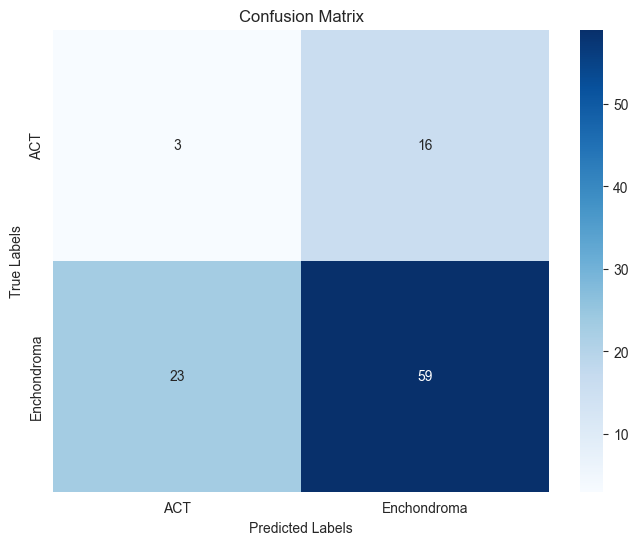

Epoch [100/100], Training Loss: 0.7231, Training Accuracy: 0.5852
Epoch [100/100], Validation Loss: 0.7402, Validation Accuracy: 0.6139
Validation AUC-ROC: 0.4387, Sensitivity: 0.7195, Specificity: 0.1579
F1-Score: 0.7516


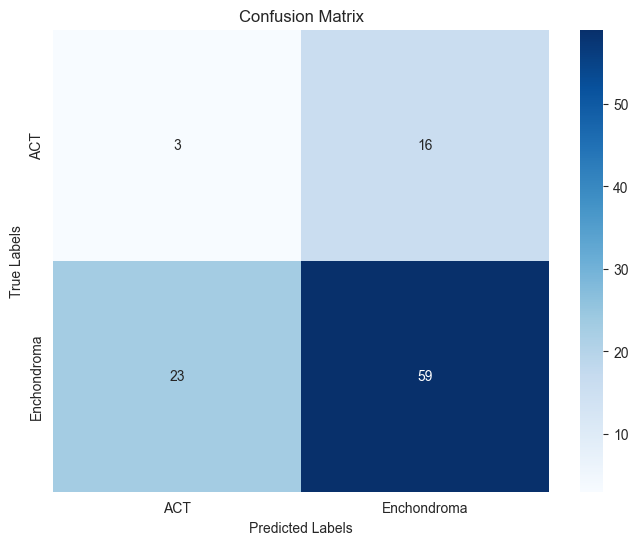

Best Validation Accuracy: 0.6139
Best F1-Score: 0.7516


In [130]:
# Training Loop

num_epochs = 100

train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

best_f1_score = 0.0
best_conf_matrix = None
best_val_accuracy = 0.0
best_model = None
best_val_loss = float("inf")

epoch_metrics_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for step, (batch) in enumerate(train_loader):
        image = batch[0].to(device) # image shape [batch size x num_channels x height x width]
        labels = batch[1].to(device) # labels shape [batch_size] = ground truth label (0 or 1) for each of the samples in a batch

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(image)
        logits = outputs.logits # outputs shape [batch size, 2] = the two columns represent the logits for each class

        # Calculate loss (softmax already applied in CELoss() to convert logits to probabilities
        loss = criterion(logits, labels) # loss value for the current batch
        
        # Backpropagation
        loss.backward()

        # Update model's parameters
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(logits, 1) 
        correct_predictions += (predicted == labels).sum().item() # count number of correct predictions in the current batch and accumulate them

        # Update running loss
        running_loss += loss.item() # accumulates loss values over multiple batches

    # Calculate training loss and accuracy for this epoch
    average_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / len(train_dataset)

    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for step, (batch) in enumerate(val_loader):
            image = batch[0].to(device)
            labels = batch[1].to(device)

            # Forward pass
            outputs = model(image)
            logits = outputs.logits

            # Calculate loss 
            loss = criterion(logits, labels)

            # Calculate accuracy
            _, predicted = torch.max(logits, 1) 
            val_correct_predictions += (predicted == labels).sum().item()
            val_predictions.append(predicted)
            val_true_labels.append(labels)

            # Update running loss
            val_running_loss += loss.item()

    # Calculate validation loss and accuracy for this epoch
    val_average_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct_predictions / len(val_dataset)

    val_losses.append(val_average_loss)
    val_accuracies.append(val_accuracy)

    # Convert each tensor to numpy array and then concatenate
    val_true = np.concatenate([t.cpu().numpy() for t in val_true_labels])
    val_preds = np.concatenate([t.cpu().numpy() for t in val_predictions])

    # Compute evaluation metrics
    val_auc = roc_auc_score(val_true, val_preds)
    val_f1_score = f1_score(val_true, val_preds)
    conf_matrix = cm(val_true, val_preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    val_sensitivity = tp / (tp + fn)
    val_specificity = tn / (tn + fp)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_conf_matrix = conf_matrix

    # Check if current validation loss is better than the best seen so far
    if val_average_loss < best_val_loss:
        best_val_loss = val_average_loss
        # Save current model as best model
        best_model = model.state_dict()
        torch.save(best_model, '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/results/best_model/experiment1_parameters.pth')
        
    epoch_metrics = {
        "Epoch": epoch + 1, 
        "Val Accuracy": val_accuracy,
        "Val Loss": val_average_loss,
        "AUC-ROC": val_auc,
        "F1-Score": val_f1_score,
        "Sensitivity": val_sensitivity,
        "Specificity": val_specificity
    }
    epoch_metrics_list.append(epoch_metrics)

    # Print evaluation metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation AUC-ROC: {val_auc:.4f}, Sensitivity: {val_sensitivity:.4f}, Specificity: {val_specificity:.4f}")
    print(f"F1-Score: {val_f1_score:.4f}")

    scheduler.step()

    # Define class labels
    class_labels = ["ACT", "Enchondroma"]

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()           

# After training loop completes
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best F1-Score: {best_f1_score:.4f}")

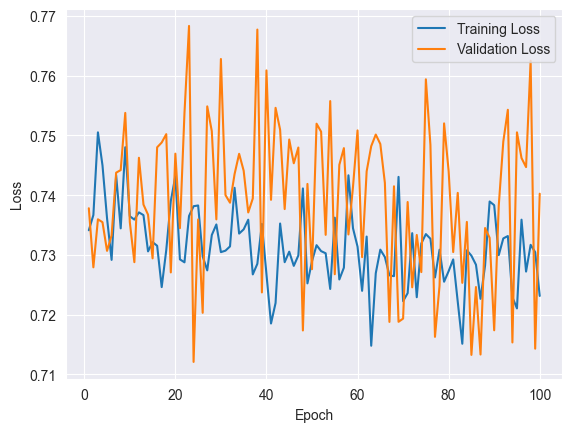

In [131]:
# Plot the training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

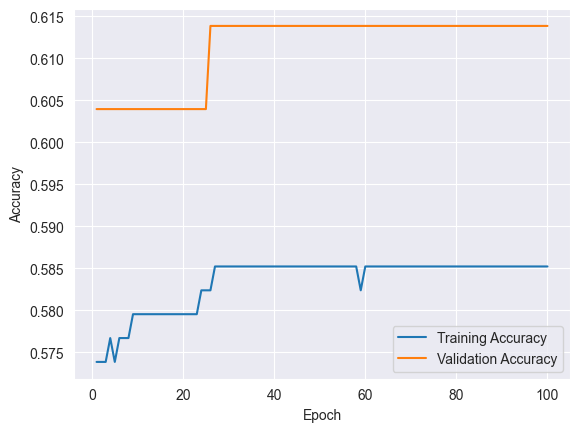

In [132]:
# Plot the training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label = "Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

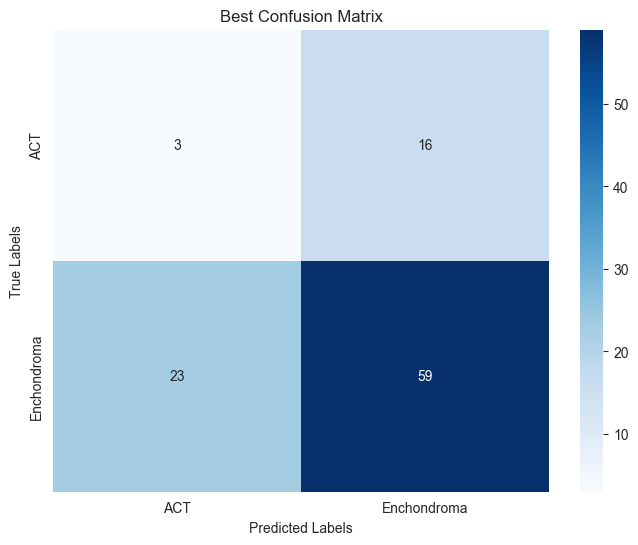

In [133]:
if best_conf_matrix is not None:
    # Plot the best confusion matrix as a heatmap based on best F1-Score
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Best Confusion Matrix")
    plt.show()

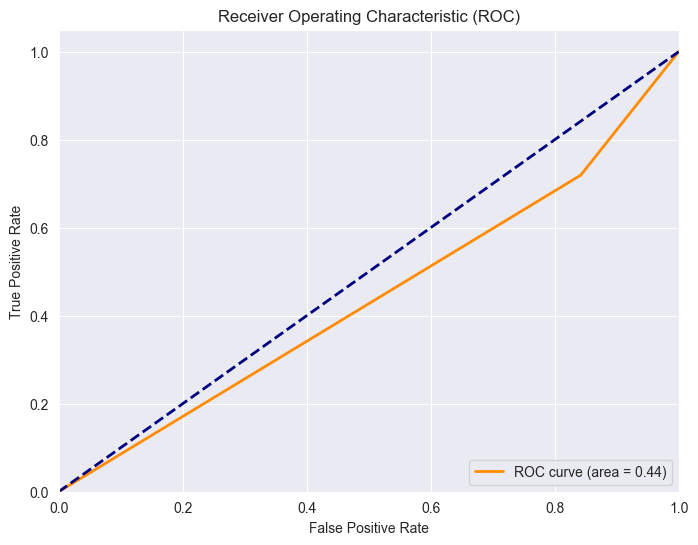

In [134]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(val_true, val_preds)

# Compute AUC
roc_auc = roc_auc_score(val_true, val_preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Plot diag
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [135]:
# Calculate metrics
metrics = {
    "Best Val Accuracy": best_val_accuracy,
    "Best F1 Score": best_f1_score,
    "Best Val Loss":best_val_loss,
    "Mean Val Accuracy": np.mean([metrics["Val Accuracy"] for metrics in epoch_metrics_list]),
    "Mean Val Loss": np.mean([metrics["Val Loss"] for metrics in epoch_metrics_list]),
    "Mean AUC-ROC": np.mean([metrics["AUC-ROC"] for metrics in epoch_metrics_list]),
    "Mean F1-Score": np.mean([metrics["F1-Score"] for metrics in epoch_metrics_list]),
    "Mean Sensitivity": np.mean([metrics["Sensitivity"] for metrics in epoch_metrics_list]),
    "Mean Specificity": np.mean([metrics["Specificity"] for metrics in epoch_metrics_list])
}

In [136]:
metrics

{'Best Val Accuracy': 0.6138613861386139,
 'Best F1 Score': 0.751592356687898,
 'Best Val Loss': 0.7120542652331866,
 'Mean Val Accuracy': 0.6113861386138614,
 'Mean Val Loss': 0.7391154638849773,
 'Mean AUC-ROC': 0.43778562259306825,
 'Mean F1-Score': 0.7494918033134591,
 'Mean Sensitivity': 0.71609756097561,
 'Mean Specificity': 0.1594736842105263}

In [137]:
# We will use MlFlow to track experiments
with mlflow.start_run():
    mlflow.pytorch.log_model(model, "best_model4")
    mlflow.log_metric("Val Accuracy", val_accuracy)
    mlflow.log_metric("Val Loss", val_average_loss)
    mlflow.log_metric("AUC-ROC", val_auc)
    mlflow.log_metric("F1-Score", val_f1_score)
    mlflow.log_metric("Sensitivity", val_sensitivity)
    mlflow.log_metric("Specificity", val_specificity)

/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [138]:
# Create new folder in 'best_models' for each experiment and save metrics.json
directory = '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/best_models'
folder_name = 'experiment_4'
new_folder_path = os.path.join(directory, folder_name)
os.makedirs(new_folder_path, exist_ok=True)

In [139]:
json_file_path = '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/best_models/experiment_4/metrics.json'

In [140]:
with open(json_file_path, "w") as json_file:
    json.dump(metrics, json_file)

print("Metrics saved to:", json_file_path)

Metrics saved to: /home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/best_models/experiment_4/metrics.json


In [141]:
# Save Model Parameters
torch.save(model.state_dict(), '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/best_models/experiment_4/model_parameters_experiment4.pth')

**Model Inference**

In [43]:
# Load trained model
model.load_state_dict(torch.load('/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/best_models/experiment_1/model_parameters_experiment1.pth'))

<All keys matched successfully>

In [44]:
# Inference
model.eval()
test_correct_predictions = 0
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for step, (batch) in enumerate(test_loader):
        image = batch[0].to(device)
        labels = batch[1].to(device)

        # Forward pass
        outputs = model(image)
        logits = outputs.logits

        # Calculate accuracy
        _, predicted = torch.max(logits, 1) 
        test_correct_predictions += (predicted == labels).sum().item()
        test_predictions.append(predicted)
        test_true_labels.append(labels)

# Calculate test accuracy
test_accuracy = test_correct_predictions / len(test_dataset)

# Convert each tensor to numpy array and then concatenate
test_true = np.concatenate([t.cpu().numpy() for t in test_true_labels])
test_preds = np.concatenate([t.cpu().numpy() for t in test_predictions])

# Compute test metrics
test_auc = roc_auc_score(test_true, test_preds)
test_f1_score = f1_score(test_true, test_preds)
test_conf_matrix = cm(test_true, test_preds)
tn, fp, fn, tp = test_conf_matrix.ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

In [45]:
# Print test metrics
test_metrics = {
    "Test Accuracy": test_accuracy,
    "AUC-ROC": test_auc,
    "F1-Score": test_f1_score,
    "Sensitivity": test_sensitivity,
    "Specificity": test_specificity
}

In [46]:
test_metrics

{'Test Accuracy': 0.717391304347826,
 'AUC-ROC': 0.5720720720720722,
 'F1-Score': 0.8219178082191781,
 'Sensitivity': 0.8108108108108109,
 'Specificity': 0.3333333333333333}

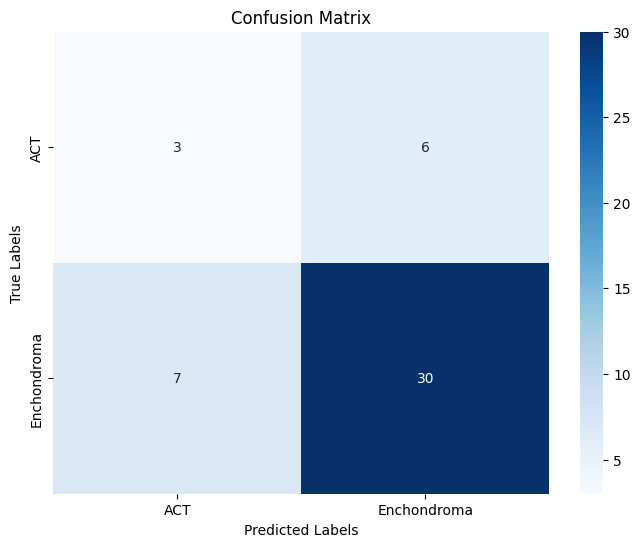

In [47]:
# Define class labels
class_labels = ["ACT", "Enchondroma"]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()   

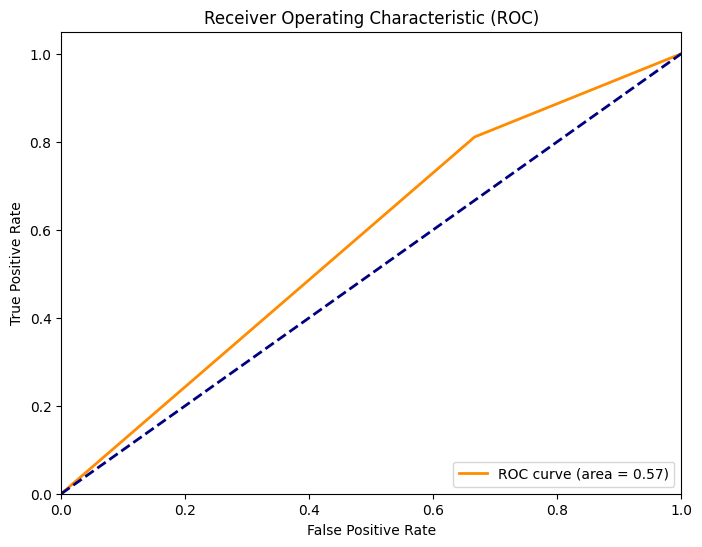

In [48]:
# Compute test ROC curve
fpr, tpr, _ = roc_curve(test_true, test_preds)

# Compute AUC
roc_auc = roc_auc_score(test_true, test_preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Plot diag
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [45]:
# Create new folder in 'best_models' for each experiment and save metrics.json
directory = '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/results'
folder_name = 'test_results'
new_folder_path = os.path.join(directory, folder_name)
os.makedirs(new_folder_path, exist_ok=True)

In [ ]:
json_file_path = '/home/inesdv/Documents/Uncertainty-in-Bone-Tumor-Classification/results/test_results/test_metrics.json'

In [ ]:
with open(json_file_path, "w") as json_file:
    json.dump(test_metrics, json_file)

print("Test metrics saved to:", json_file_path)

**Explainability**

In [49]:
import shap

In [50]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Call the original model's forward pass and return the logits
        return self.model(x).logits

In [51]:
model_wrapper = ModelWrapper(model)

In [56]:
# Apply SHAP on training images to see how the model is predicting during the training phase
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
images, labels = next(iter(train_loader))

In [58]:
print(labels)

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1])


In [68]:
# We choose 2 images with label 0 and 2 images with label 1 to have equal number of samples for each class
background_train_images = torch.stack((images[5], images[0], images[18], images[2])) # shape [4, 3, 224, 224]
background_train_labels = torch.stack((labels[5], labels[0], labels[18], labels[2])) # shape torch.Size([4])

In [69]:
train_images = torch.stack((images[2], images[3], images[23], images[29]))
train_labels = torch.stack((labels[2], labels[3], labels[23], labels[29]))

In [70]:
print('Class:      ', end='')
[print('{:6}'.format(x), end='') for x in range(0, 2)];
print('\nBackground: ', end='')
[print('{:6.1%}'.format(x), end='') 
    for x in np.bincount(background_train_labels)/background_train_labels.shape[0]];
print('\nTrain:       ', end='')
[print('{:6.1%}'.format(x), end='')
     for x in np.bincount(train_labels)/train_labels.shape[0]];

Class:           0     1
Background:  50.0% 50.0%
Train:        50.0% 50.0%

In [71]:
# Get probabilities with the train_images
outputs = model(train_images.to(device))
logits = outputs.logits
train_probabilities = torch.nn.functional.softmax(logits, dim=1)
train_predicted = logits.max(1, keepdim=True)[1] 
train_predicted_np = train_predicted.cpu().numpy()
train_probabilities_np = train_probabilities.cpu().detach().numpy()

In [72]:
# Initialize Deep Explainer
expl = shap.DeepExplainer(model_wrapper, background_train_images.to(device))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


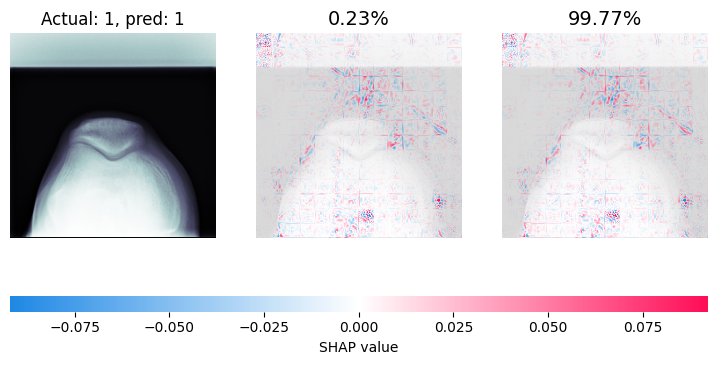

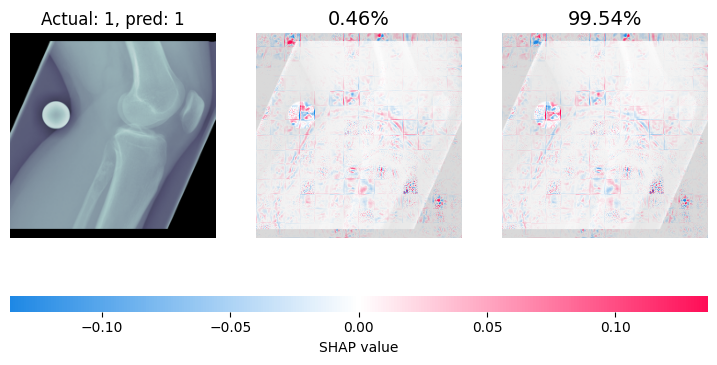

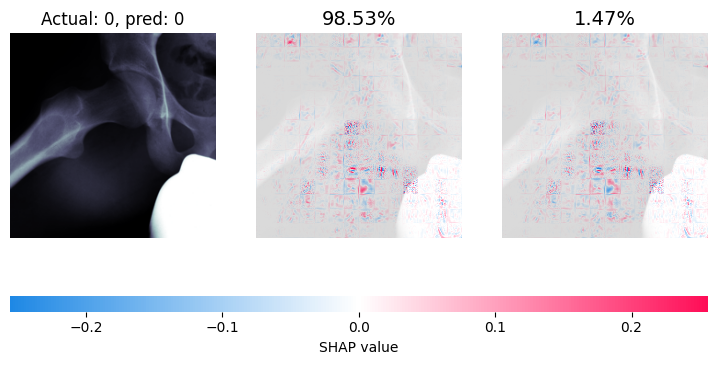

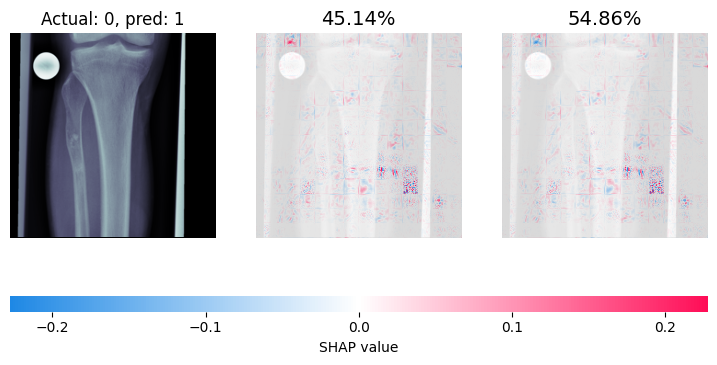

In [73]:
# Visualization of SHAP values for train_images
for i in range(len(train_images)):
    tr = train_images[[i]]
    sv = expl.shap_values(tr)
    sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
    tn = np.swapaxes(np.swapaxes(tr.numpy(), 1, -1), 1, 2)
    
    # Prepare the attribution plot, but do not draw it yet
    # We will add more info to the plots later in the code
    shap.image_plot(sn, tn, show=False)
    
    # Prepare to augment the plot
    fig = plt.gcf()
    allaxes = fig.get_axes()
    
    # Show the actual/predicted class
    allaxes[0].set_title('Actual: {}, pred: {}'.format(
            train_labels[i], train_predicted_np[i][0]))
    
    # Show the probability of each class
    for x in range(1, len(allaxes)-1):
        probability = train_probabilities[i][x - 1]  # Get the probability for the current class
        formatted_probability = "{:.2%}".format(probability)  # Format as a percentage
        allaxes[x].set_title(formatted_probability, fontsize=14)
    plt.show()

In [75]:
# Apply SHAP on test images
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)
images, labels = next(iter(test_loader))

In [77]:
# We choose 2 images with label 0 and 2 images with label 1 to have equal number of samples for each class
background_test_images = torch.stack((images[0], images[1], images[10], images[2])) # shape [4, 3, 224, 224]
background_test_labels = torch.stack((labels[0], labels[1], labels[10], labels[2])) # shape torch.Size([4])

In [78]:
test_images = torch.stack((images[3], images[4], images[13], images[21]))
test_labels = torch.stack((labels[3], labels[4], labels[13], labels[21]))

In [81]:
print('Class:      ', end='')
[print('{:6}'.format(x), end='') for x in range(0, 2)];
print('\nBackground: ', end='')
[print('{:6.1%}'.format(x), end='') 
    for x in np.bincount(background_test_labels)/background_test_labels.shape[0]];
print('\nTest:       ', end='')
[print('{:6.1%}'.format(x), end='')
     for x in np.bincount(test_labels)/test_labels.shape[0]];

Class:           0     1
Background:  50.0% 50.0%
Test:        50.0% 50.0%

In [82]:
# Get probabilities with the test_images
outputs = model(test_images.to(device))
logits = outputs.logits
test_probabilities = torch.nn.functional.softmax(logits, dim=1)
test_predicted = logits.max(1, keepdim=True)[1] 
test_predicted_np = test_predicted.cpu().numpy()
test_probabilities_np = test_probabilities.cpu().detach().numpy()

In [83]:
# Initialize Deep Explainer
expl = shap.DeepExplainer(model_wrapper, background_test_images.to(device))

In [74]:
# Trying the same for test images
images, labels = next(iter(test_loader))

background = images[:4]
test_images = images[4:6]

In [75]:
# Initialize Deep Explainer
explainer = shap.DeepExplainer(model_wrapper, background.to(device))

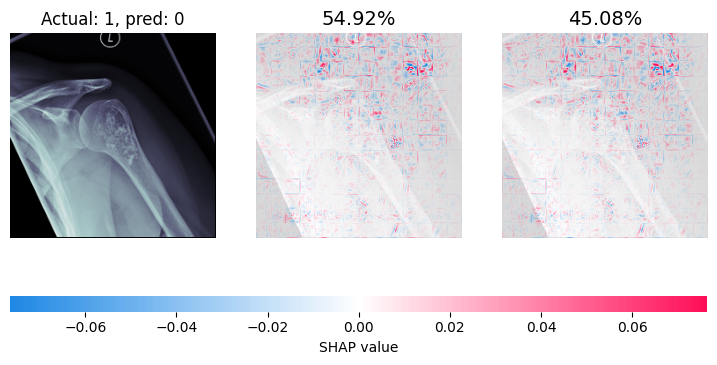

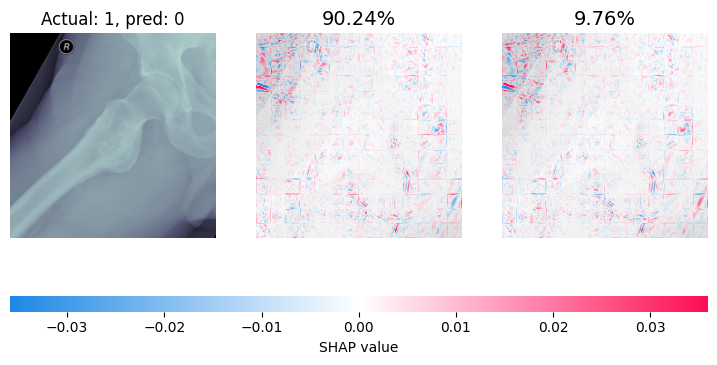

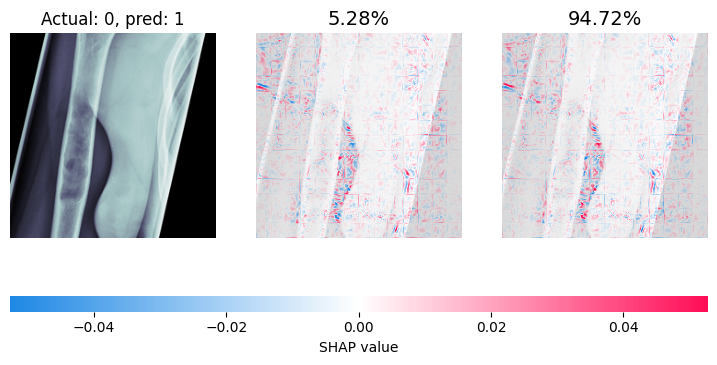

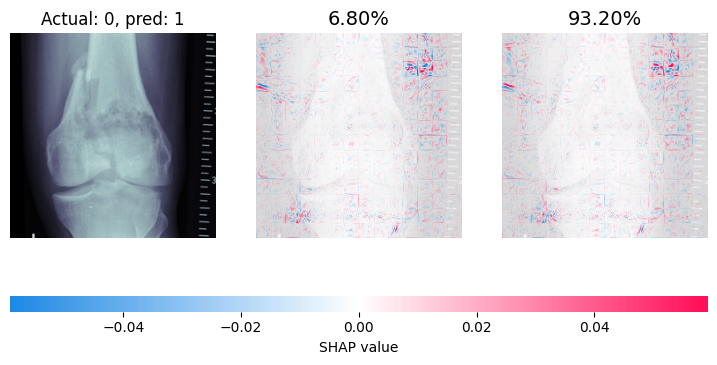

In [84]:
# Visualization of SHAP values for test_images
for i in range(len(test_images)):
    ti = test_images[[i]]
    sv = expl.shap_values(ti)
    sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
    tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)
    
    # Prepare the attribution plot, but do not draw it yet
    # We will add more info to the plots later in the code
    shap.image_plot(sn, tn, show=False)
    
    # Prepare to augment the plot
    fig = plt.gcf()
    allaxes = fig.get_axes()
    
    # Show the actual/predicted class
    allaxes[0].set_title('Actual: {}, pred: {}'.format(
            test_labels[i], test_predicted_np[i][0]))
    
    # Show the probability of each class
    for x in range(1, len(allaxes)-1):
        probability = test_probabilities[i][x - 1]  # Get the probability for the current class
        formatted_probability = "{:.2%}".format(probability)  # Format as a percentage
        allaxes[x].set_title(formatted_probability, fontsize=14)
    plt.show()

In [76]:
# Calculate SHAP values for the chosen image
shap_values = explainer.shap_values(test_images) # list of arrays where each one corresponds to the SHAP values for the chosen training image

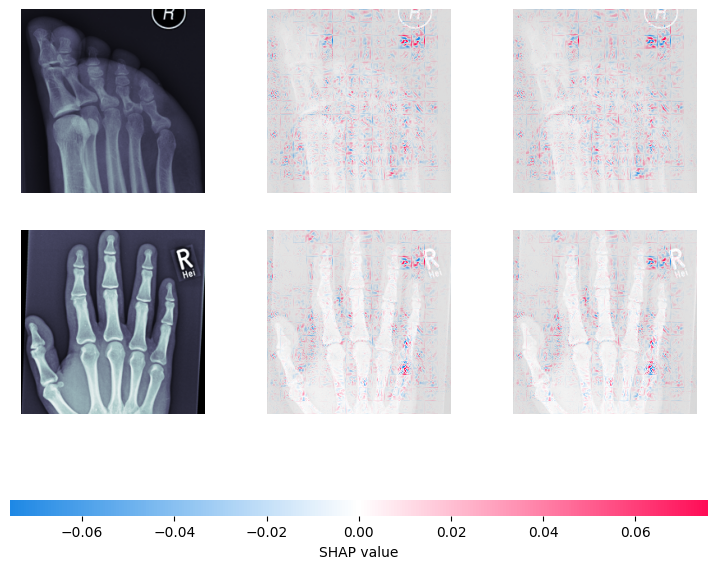

In [77]:
# Visualize the SHAP values for the chosen image
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, test_numpy)